In [1]:
import pandas as pd
import numpy as np
import os
import collections
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy import optimize
import pickle
import time
import random
import itertools
from scipy.stats import ttest_ind, ttest_1samp
import warnings
import fastcluster
from sklearn.decomposition import NMF



local_metadata_file = "/Users/felix/Documents/DPhil/methylation/taps_tissue_atlas/tissue_atlas_v3/metadata/Atlas_V3_Metadata_New.pickle"

with open(local_metadata_file, 'rb') as f:
    project_metadata = pickle.load(f)

# Load all the variables into memory    
project_dir = project_metadata['project_dir']
atlas_dir = project_metadata['atlas_dir'] 
metadata_dir = project_metadata['metadata_dir']
gene_exp_dir = project_metadata['gene_exp_dir']
intersections_dir = project_metadata['intersections_dir']
id_tissue_map = project_metadata["id_tissue_map"]
tissue_id_map = project_metadata["tissue_id_map"]
blood_cell_types = project_metadata["blood_cell_types"]
somatic_tissue_types = project_metadata["somatic_tissue_types"]
healthy_tissue_types = project_metadata["healthy_tissue_types"]
cancer_tissue_types = project_metadata["cancer_tissue_types"]
diseased_tissue_types = project_metadata["diseased_tissue_types"]
tissues_with_tumour = project_metadata["tissues_with_tumour"]
tissue_order = project_metadata["tissue_order"]
genomic_features = project_metadata["genomic_features"]
sample_outliers = project_metadata["sample_outliers"]
# healthy_high_cov_samples = project_metadata["healthy_high_cov_samples"]
genomic_feature_colnames = project_metadata["genomic_feature_colnames"]
genomic_regions_dir = project_metadata['genomic_regions_dir']



# filename = "TAPSbeta_Atlas.all_samples.CpG.merged.filtered.TAPSbeta_hmm.healthy_high_cov_samples.test3_fixed_state.Filtered_blocks.Grail_filtering_criteria.rC.csv"
# filename = "TAPSbeta_Atlas.all_samples.CpG.merged.filtered.TAPSbeta_hmm.healthy_high_cov_samples.test3_fixed_state.Filtered_blocks.Grail_filtering_criteria.rC.csv"
# filename="TAPSbeta_Atlas.all_samples.CpG.merged.filtered.TAPSbeta_hmm.all_samples.test5_2hiddenstates_mincov3_astair_snp_filter.Filtered_blocks.large_blocks_4cpg.rC.csv"
# filename="CAPS_Atlas.all_samples.CpG.merged.filtered.CAPS_hmm.all_samples.test5_2hiddenstates_mincov3_astair_snp_filter.Filtered_blocks.large_blocks_4cpg.rC.csv"
# filename = "CAPS.all_samples.Tissue_Group_DMBs.all_delta_quants0.CAPS_hmm.all_samples.test7_2hiddenstates_mincov3_snp_reindex.Filtered_blocks.large_blocks_4cpg.csv"

filename="CAPS_Atlas.all_samples.CpG.merged.filtered.CAPS_hmm.all_samples.test7_2hiddenstates_mincov3_snp_reindex.Filtered_blocks.large_blocks_4cpg.rC.csv"


# files_dir = "/Users/felix/Documents/DPhil/methylation/taps_tissue_atlas/tissue_atlas_v3/"
files_dir = "/Users/felix/Documents/DPhil/methylation/taps_tissue_atlas/tissue_atlas_v3/example_data/"

block_atlas = pd.read_csv(files_dir + filename,
                         sep='\t',
                         # nrows=1000,
                         ).set_index('chr_start_end')




In [2]:
cbar_shrink=0.3

### Filter cols

In [3]:
df = block_atlas.loc[:,[u for u in block_atlas.columns if 'Cirrhosis' not in u]]
df = df.loc[:,[u for u in df.columns if 'Pancreatitis' not in u]]
# df = df.rename(columns={u:u.replace("_TAPSbeta_RATE","") for u in df.columns})
# df = df.rename(columns={u:u.replace("_CAPS_RATE","") for u in df.columns})
df = df.dropna()

df = df.loc[:,[u for u in df.columns if u not in sample_outliers]]
# df = df.loc[:,[u for u in df.columns if u in list(id_tissue_map.keys())]]


In [4]:
os.getcwd()

'/Users/felix/Documents/DPhil/methylation/taps_tissue_atlas/tissue_atlas_v3'

In [5]:
healthy_df = df[[u for u in df.columns if id_tissue_map[u] in healthy_tissue_types]]
tumour_df = df[[u for u in df.columns if id_tissue_map[u] in cancer_tissue_types]]

In [6]:
# ## Calculate variance across rows, excluding the non-numeric columns
# healthy_df['variance'] = healthy_df.var(axis=1)

# topn_var = 100000
# # Sort the DataFrame by 'variance' in descending order and select top n
# healthy_df = healthy_df.sort_values('variance', ascending=False).head(topn_var)

# # Drop the 'variance' column if it's no longer needed
# healthy_df = healthy_df.drop(columns=['variance'])

### NMF 

NMF finds a decomposition of input data X into two matrices W and H, by minimising the distance between X and the matrix product W * H

So we reduce a dataframe with n samples and k regions to a dataframe with m LMCs and still k regions. Notice number of regions stays the same.

So for our healthy_df, it is effectively reducing our df of (many_rows, 77) to a df of shape (many_rows, 22), when k=22.

In [7]:

# Assuming 'methylation_df' is your DataFrame

# Perform NMF to extract 20 LMCs
n_lmc = 22
nmf = NMF(n_components=n_lmc, init='random', random_state=0)
lmc = nmf.fit_transform(healthy_df)


/Users/felix/opt/anaconda3/envs/local_ds/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [8]:
# plt.figure(figsize=(12, 9))

# # Transpose the weight_vectors to have original features as rows
# sns.heatmap(weight_vectors.T, cmap='viridis', yticklabels=healthy_df.columns)

# # Rotate the y-axis tick labels for better readability
# plt.yticks(rotation=0)

# plt.title(f"Proportional contribution to each of the {n_lmc} LMC signatures")
# plt.ylabel('Tissue Samples')
# plt.xlabel('LMCs')

# # Display the heatmap
# plt.show()

### Get top feature weights by LMC

- Note: the LMC itself is the weight: there is no weighting we can access which is separate to the LMC

In [9]:

# n_top_regions = 50
# top_regions_per_lmc = pd.DataFrame(index=range(n_top_regions))

# for i in range(n_lmc):
#     top_indices = ranked_regions[:n_top_regions, i]  # Top 10 for illustration
#     top_weights = lmc[top_indices, i]
#     top_regions_per_lmc[f'LMC_{i+1}'] = top_weights

In [10]:
ranked_regions = np.argsort(-lmc, axis=0)  # Negate to sort in descending order

In [11]:
# Assuming that 'healthy_df' has an index or a column with the genomic region names
# and 'ranked_regions' is already computed as before

n_top_regions = 50
top_regions_indices_per_lmc = pd.DataFrame(index=range(n_top_regions))
top_regions_weights_per_lmc = pd.DataFrame(index=range(n_top_regions))

# Retrieve the names of the genomic regions from the DataFrame index or a specific column
genomic_region_names = healthy_df.index  # Replace with healthy_df['region_column_name'] if using a column

for i in range(n_lmc):
    top_indices = ranked_regions[:n_top_regions, i]  # Top regions for the ith LMC
    top_weights = lmc[top_indices, i]
    top_region_names = genomic_region_names[top_indices]  # Get the names of the top regions
    
    # Store the names and weights in separate DataFrames for the ith LMC
    top_regions_indices_per_lmc[f'LMC_{i+1}'] = top_region_names
    top_regions_weights_per_lmc[f'LMC_{i+1}'] = top_weights

# Assuming you want to see the results
# top_regions_indices_per_lmc.head(), top_regions_weights_per_lmc.head()


<AxesSubplot:ylabel='chr_start_end'>

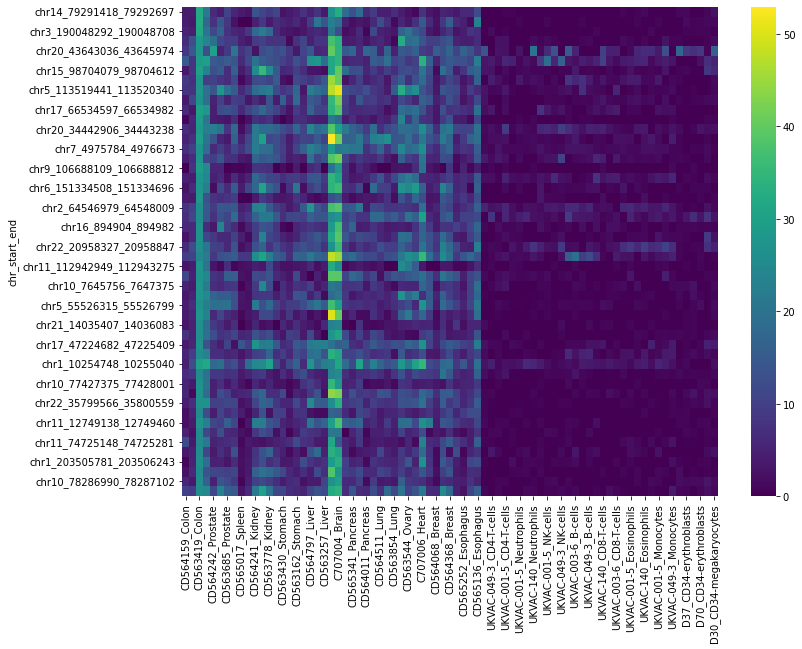

In [12]:
plt.figure(figsize=(12, 9))

# Transpose the weight_vectors to have original features as rows
regions = list(top_regions_indices_per_lmc['LMC_1'])

sns.heatmap(healthy_df.loc[regions,:], cmap='viridis')

In [13]:
# Define the number of top regions to consider for each LMC
n_top_regions = 50  # The number of top regions for each LMC

# Initialize an empty list to hold the unique top regions
unique_top_regions = []

# Iterate over each LMC and collect the top regions while maintaining their order and avoiding duplicates
for i in range(n_lmc):
    regions = list(top_regions_indices_per_lmc[f'LMC_{i+1}'])
    for region in regions:
        if region not in unique_top_regions:
            unique_top_regions.append(region)

# Now that we have all the unique top regions in order, let's subset the healthy_df DataFrame
top_regions_df = healthy_df.loc[unique_top_regions]




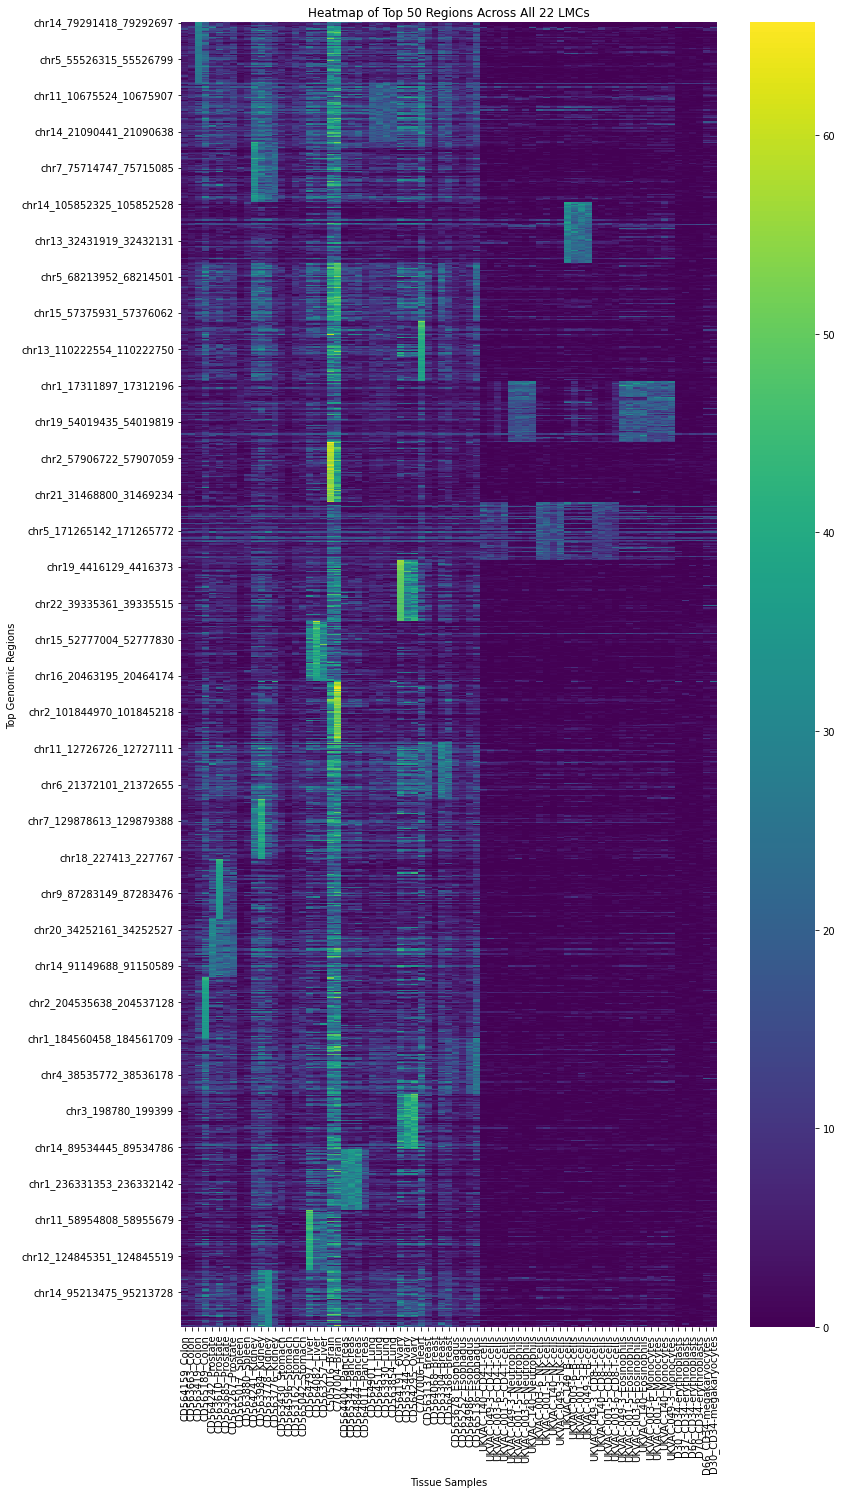

In [14]:
# Plot the heatmap
plt.figure(figsize=(12, 24))
sns.heatmap(top_regions_df, cmap='viridis', yticklabels=30, xticklabels=True)
plt.title(f"Heatmap of Top 50 Regions Across All {n_lmc} LMCs")
plt.xlabel('Tissue Samples')
plt.ylabel('Top Genomic Regions')
plt.show()

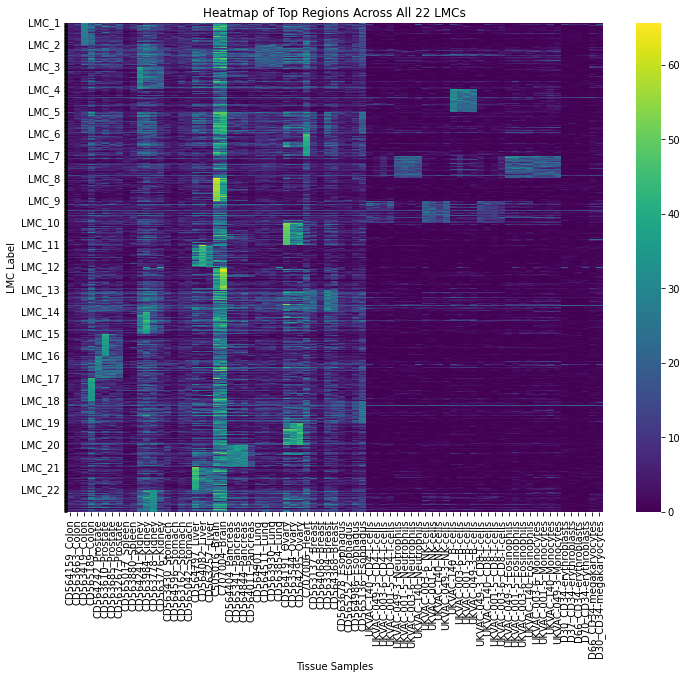

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of top regions to consider for each LMC
n_top_regions = 50

# Initialize a list to hold the unique top regions and a list for their corresponding LMC labels
unique_top_regions = []
lmc_labels = []

# Iterate over each LMC to collect the top regions and their labels
for i in range(n_lmc):
    regions = list(top_regions_indices_per_lmc[f'LMC_{i+1}'])
    unique_top_regions.extend(regions)
    # Extend the label list with the current LMC label, repeated for the number of regions added
    lmc_labels.extend([f'LMC_{i+1}'] * len(regions))

# Now subset the healthy_df DataFrame with the unique top regions
top_regions_df = healthy_df.loc[unique_top_regions]

# Plot the heatmap
plt.figure(figsize=(12, 9))
ax = sns.heatmap(top_regions_df, cmap='viridis', yticklabels=lmc_labels, xticklabels=True)
plt.title(f"Heatmap of Top Regions Across All {n_lmc} LMCs")
plt.xlabel('Tissue Samples')
plt.ylabel('LMC Label')

# Modify the yticks to only show one label per LMC
yticks = ax.get_yticks()
# Set every nth label to be visible (n = number of regions per LMC), the rest will be set to empty string
ax.set_yticklabels(['' if (idx % n_top_regions) else label for idx, label in enumerate(lmc_labels)])

plt.show()


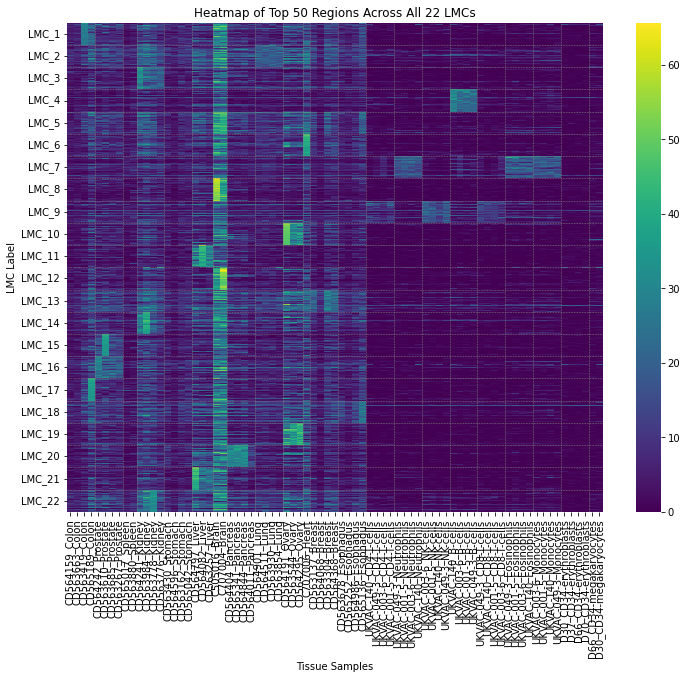

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of top regions to consider for each LMC
n_top_regions = 50

# Collect the top regions for each LMC while maintaining the order and avoiding duplicates
unique_top_regions = []
for i in range(n_lmc):
    regions = list(top_regions_indices_per_lmc[f'LMC_{i+1}'])
    unique_top_regions.extend(regions)

# Subset the healthy_df DataFrame with the unique top regions
top_regions_df = healthy_df.loc[unique_top_regions]

# Parse out the tissue names from the column headers and find the indices for tissue group changes
tissue_groups = top_regions_df.columns.str.rsplit('_', n=1).str[-1]
change_indices = [i for i in range(1, len(tissue_groups)) if tissue_groups[i] != tissue_groups[i-1]]

# Plot the heatmap
plt.figure(figsize=(12, 9))
ax = sns.heatmap(top_regions_df, cmap='viridis', yticklabels=lmc_labels, xticklabels=True)

# Set the y-ticks to be at the midpoint of the regions for each LMC
midpoints = [((i*n_top_regions) + ((i+1)*n_top_regions))/2 for i in range(n_lmc)]
ax.set_yticks(midpoints)
ax.set_yticklabels([f'LMC_{i+1}' for i in range(n_lmc)], rotation=0, ha='right')

# Add grey horizontal lines indicating the border between LMCs
for i in range(1, n_lmc):
    plt.axhline(i*n_top_regions, color='grey', linestyle='--', linewidth=0.5)

# Add vertical lines indicating the border between tissue groups
for index in change_indices:
    plt.axvline(x=index, color='grey', linestyle='--', linewidth=0.5)

plt.title(f"Heatmap of Top 50 Regions Across All {n_lmc} LMCs")
plt.xlabel('Tissue Samples')
plt.ylabel('LMC Label')
plt.show()


In [17]:
top_regions_df

CD564159_Colon  CD563663_Colon  CD563419_Colon  \
chr_start_end                                                               
chr14_79291418_79292697             3.900           4.080          32.100   
chr10_122179849_122180016           4.050           3.425          32.325   
chr3_190048292_190048708            5.225           4.525          31.675   
chr15_65088909_65089239             6.580          12.900          28.660   
chr20_43643036_43645974             8.325          14.675          28.125   
...                                   ...             ...             ...   
chr2_9368199_9368513                3.000           2.280           3.200   
chr5_143009912_143011204            6.475           3.975           4.450   
chr8_29072891_29073021              0.925           2.350           3.325   
chr2_135051645_135051756           13.175          13.450           8.300   
chr10_80158932_80159164             4.500           5.510           9.230   

                           CD565189_Colon  CD564242_Prostate  \
chr_start_end                                                  
chr14_79291418_79292697            21.600              6.260   
chr10_122179849_122180016          17.775              7.575   
chr3_190048292_190048708           20.550             11.650   
chr15_65088909_65089239            23.860             19.260   
chr20_43643036_43645974            12.450             30.350   
...                                   ...                ...   
chr2_9368199_9368513               17.080             10.960   
chr5_143009912_143011204           13.125              4.650   
chr8_29072891_29073021              4.950              5.825   
chr2_135051645_135051756           17.125              9.725   
chr10_80158932_80159164            13.930             15.700   

                           CD563610_Prostate  CD563685_Prostate  \
chr_start_end                                                     
chr14_79291418_79292697                4.080             10.440   
chr10_122179849_122180016             14.425              8.675   
chr3_190048292_190048708              16.275              7.500   
chr15_65088909_65089239               11.180              9.180   
chr20_43643036_43645974                5.000              9.050   
...                                      ...                ...   
chr2_9368199_9368513                  20.860              6.980   
chr5_143009912_143011204               7.550              6.525   
chr8_29072891_29073021                17.400              2.800   
chr2_135051645_135051756              16.625              8.725   
chr10_80158932_80159164               12.690             10.970   

                           CD563267_Prostate  CD565017_Spleen  \
chr_start_end                                                   
chr14_79291418_79292697                5.420            3.920   
chr10_122179849_122180016              2.550            0.000   
chr3_190048292_190048708               5.500            4.900   
chr15_65088909_65089239                9.180            4.580   
chr20_43643036_43645974               20.525            7.550   
...                                      ...              ...   
chr2_9368199_9368513                   8.860            2.300   
chr5_143009912_143011204               4.475            4.250   
chr8_29072891_29073021                 5.225            0.000   
chr2_135051645_135051756              18.275            4.025   
chr10_80158932_80159164               11.220            7.030   

                           CD563880_Spleen  ...  UKVAC-003-6_Monocytes  \
chr_start_end                               ...                          
chr14_79291418_79292697              2.700  ...                  0.000   
chr10_122179849_122180016            0.000  ...                  0.000   
chr3_190048292_190048708             8.400  ...                  1.200   
chr15_65088909_65089239              3.300  ...                  0.000   
chr20_43643036_43645974       

In [18]:

# Calculate correlations between original columns and LMCs
lmc_df = pd.DataFrame(lmc, index=healthy_df.index)
correlation_matrix = pd.DataFrame(np.corrcoef(healthy_df.T, lmc_df.T)[:healthy_df.shape[1], healthy_df.shape[1]:],
                                  index=healthy_df.columns, columns=[f"LMC_{i+1}" for i in range(n_lmc)])




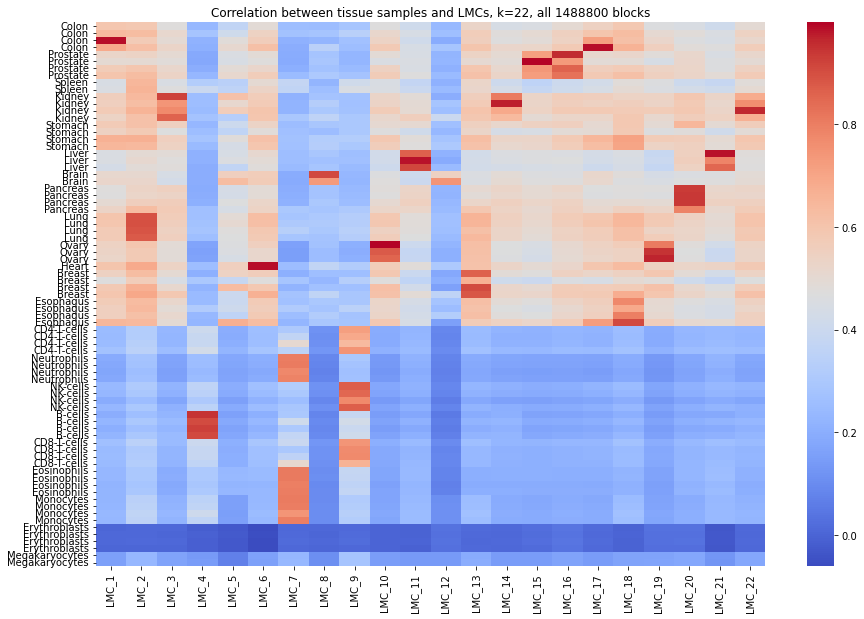

In [19]:
# Plotting the heatmap
plt.figure(figsize=(15, 10))
tissue_labels = [id_tissue_map[col] for col in healthy_df.columns]
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm',yticklabels=tissue_labels)
# plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, top {topn_var} variance blocks")
plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, all {len(healthy_df)} blocks")



# plt.ylabel("Original Features")
# plt.xlabel("Latent Methylation Components")
plt.show()

In [20]:
custom_lmc_order = [1,17,16,15,3,14,22,18,21,11,8,12,20,2,10,19,6,13,9,7,4,5]

In [21]:
lmc_string_order = [f"LMC_{u}" for u in custom_lmc_order]
[u for u in correlation_matrix.columns if u not in lmc_string_order]


[]

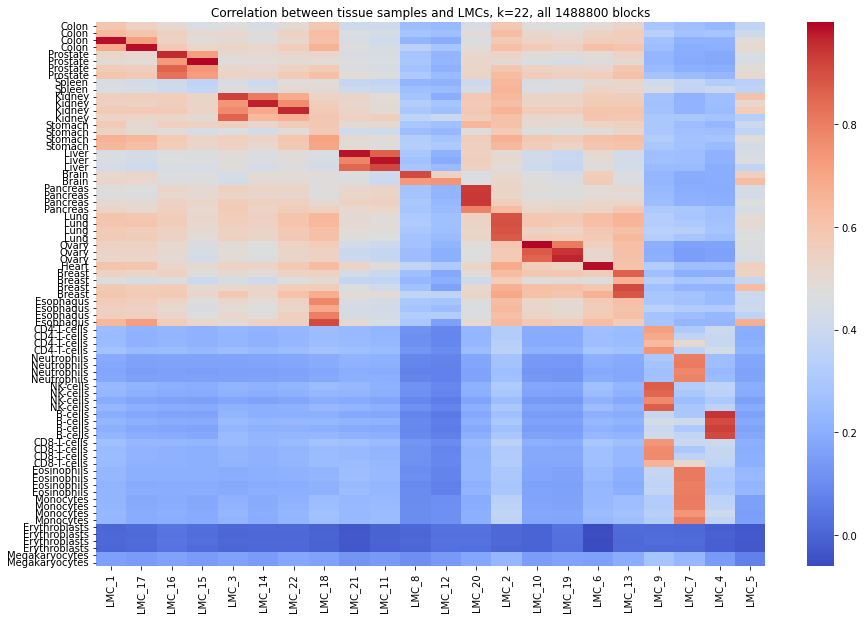

In [22]:
# Plotting the heatmap
plt.figure(figsize=(15, 10))
tissue_labels = [id_tissue_map[col] for col in healthy_df.columns]
sns.heatmap(correlation_matrix[lmc_string_order], annot=False, cmap='coolwarm',yticklabels=tissue_labels)
# plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, top {topn_var} variance blocks")
plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, all {len(healthy_df)} blocks")



# plt.ylabel("Original Features")
# plt.xlabel("Latent Methylation Components")
plt.show()

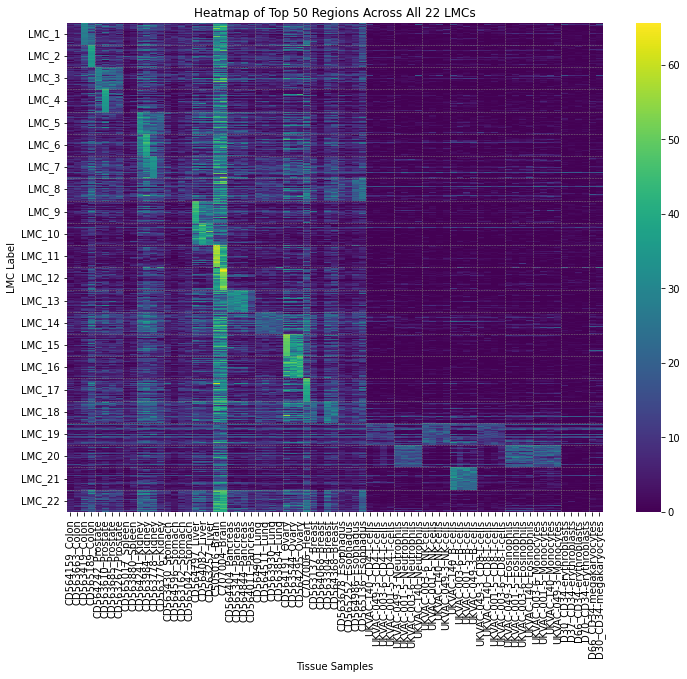

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of top regions to consider for each LMC
n_top_regions = 50

# Collect the top regions for each LMC while maintaining the order and avoiding duplicates
unique_top_regions = []
for k in custom_lmc_order:
    regions = list(top_regions_indices_per_lmc[f'LMC_{k}'])
    unique_top_regions.extend(regions)

# Subset the healthy_df DataFrame with the unique top regions
top_regions_df = healthy_df.loc[unique_top_regions]

# Parse out the tissue names from the column headers and find the indices for tissue group changes
tissue_groups = top_regions_df.columns.str.rsplit('_', n=1).str[-1]
change_indices = [i for i in range(1, len(tissue_groups)) if tissue_groups[i] != tissue_groups[i-1]]

# Plot the heatmap
plt.figure(figsize=(12, 9))
ax = sns.heatmap(top_regions_df, cmap='viridis', yticklabels=lmc_labels, xticklabels=True)

# Set the y-ticks to be at the midpoint of the regions for each LMC
midpoints = [((i*n_top_regions) + ((i+1)*n_top_regions))/2 for i in range(n_lmc)]
ax.set_yticks(midpoints)
ax.set_yticklabels([f'LMC_{i+1}' for i in range(n_lmc)], rotation=0, ha='right')

# Add grey horizontal lines indicating the border between LMCs
for i in range(1, n_lmc):
    plt.axhline(i*n_top_regions, color='grey', linestyle='--', linewidth=0.5)

# Add vertical lines indicating the border between tissue groups
for index in change_indices:
    plt.axvline(x=index, color='grey', linestyle='--', linewidth=0.5)

plt.title(f"Heatmap of Top 50 Regions Across All {n_lmc} LMCs")
plt.xlabel('Tissue Samples')
plt.ylabel('LMC Label')
plt.show()


In [24]:
# # Calculate correlations between original columns and LMCs
# lmc_df = pd.DataFrame(lmc, index=healthy_df.index)
# correlation_matrix = pd.DataFrame(np.corrcoef(healthy_df.T, lmc_df.T)[:healthy_df.shape[1], healthy_df.shape[1]:],
#                                   index=healthy_df.columns, columns=[f"LMC_{i+1}" for i in range(n_lmc)])

# # Find the best correlating LMC for each tissue sample
# best_correlating_lmc = correlation_matrix.idxmax(axis=1)

# # Reorder the columns of the correlation matrix based on the best correlation
# reordered_correlation_matrix = correlation_matrix[best_correlating_lmc.values]

# # Plotting the heatmap
# plt.figure(figsize=(15, 10))
# sns.heatmap(reordered_correlation_matrix, annot=False, cmap='coolwarm')
# plt.title(f"Correlation between tissue samples and reordered LMCs, k={n_lmc}, all {len(healthy_df)} blocks")
# plt.ylabel("Original Features")
# plt.xlabel("Reordered Latent Methylation Components")
# plt.show()


### Repeat for tumour samples

In [25]:
# ## Calculate variance across rows, excluding the non-numeric columns
# tumour_df['variance'] = tumour_df.var(axis=1)

# topn_var = 100000
# # Sort the DataFrame by 'variance' in descending order and select top n
# tumour_df = tumour_df.sort_values('variance', ascending=False).head(topn_var)

# # Drop the 'variance' column if it's no longer needed
# tumour_df = tumour_df.drop(columns=['variance'])

In [26]:

# Assuming 'methylation_df' is your DataFrame

# Perform NMF to extract 20 LMCs

n_lmc = 10
nmf = NMF(n_components=n_lmc, init='random', random_state=0)
lmc = nmf.fit_transform(tumour_df)


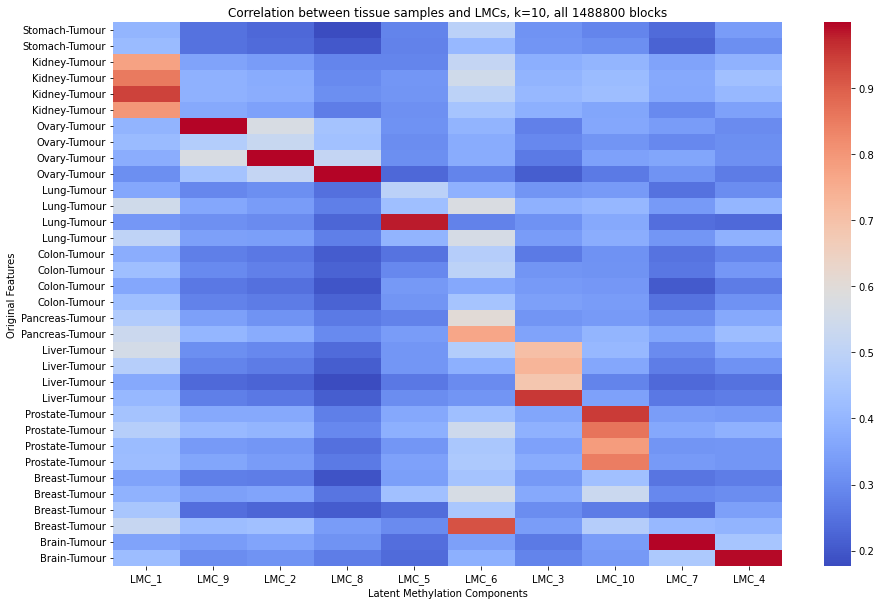

In [27]:

# Calculate correlations between original columns and LMCs
lmc_df = pd.DataFrame(lmc, index=tumour_df.index)
correlation_matrix = pd.DataFrame(np.corrcoef(tumour_df.T, lmc_df.T)[:tumour_df.shape[1], tumour_df.shape[1]:],
                                  index=tumour_df.columns, columns=[f"LMC_{i+1}" for i in range(n_lmc)])


custom_lmc_order = [1,9,2,8,5,6,3,10,7,4]
lmc_string_order = [f"LMC_{u}" for u in custom_lmc_order]
[u for u in correlation_matrix.columns if u not in lmc_string_order]

tissue_labels = [id_tissue_map[col] for col in tumour_df.columns]

# Plotting the heatmap
plt.figure(figsize=(15, 10))
# sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
sns.heatmap(correlation_matrix[lmc_string_order], annot=False, cmap='coolwarm',yticklabels=tissue_labels)
# plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, top {topn_var} variance blocks")
plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, all {len(tumour_df)} blocks")
plt.ylabel("Original Features")
plt.xlabel("Latent Methylation Components")
plt.show()

In [28]:
ranked_regions = np.argsort(-lmc, axis=0)  # Negate to sort in descending order


# Assuming that 'healthy_df' has an index or a column with the genomic region names
# and 'ranked_regions' is already computed as before

n_top_regions = 50
top_regions_indices_per_lmc = pd.DataFrame(index=range(n_top_regions))
top_regions_weights_per_lmc = pd.DataFrame(index=range(n_top_regions))

# Retrieve the names of the genomic regions from the DataFrame index or a specific column
genomic_region_names = healthy_df.index  # Replace with healthy_df['region_column_name'] if using a column

for i in range(n_lmc):
    top_indices = ranked_regions[:n_top_regions, i]  # Top regions for the ith LMC
    top_weights = lmc[top_indices, i]
    top_region_names = genomic_region_names[top_indices]  # Get the names of the top regions
    
    # Store the names and weights in separate DataFrames for the ith LMC
    top_regions_indices_per_lmc[f'LMC_{i+1}'] = top_region_names
    top_regions_weights_per_lmc[f'LMC_{i+1}'] = top_weights

# Assuming you want to see the results
# top_regions_indices_per_lmc.head(), top_regions_weights_per_lmc.head()


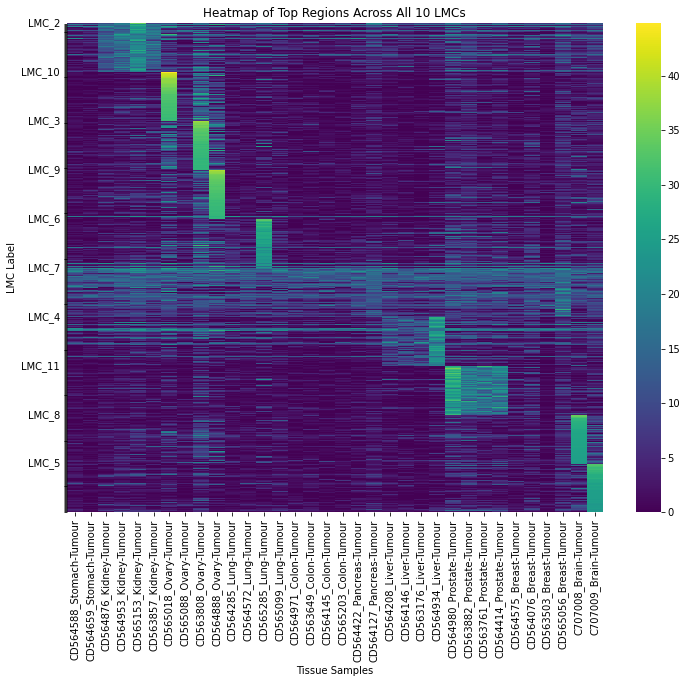

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of top regions to consider for each LMC
n_top_regions = 50

# Initialize a list to hold the unique top regions and a list for their corresponding LMC labels
unique_top_regions = []
lmc_labels = []

# Iterate over each LMC to collect the top regions and their labels
for i in custom_lmc_order:
    regions = list(top_regions_indices_per_lmc[f'LMC_{i}'])
    unique_top_regions.extend(regions)
    # Extend the label list with the current LMC label, repeated for the number of regions added
    lmc_labels.extend([f'LMC_{i+1}'] * len(regions))

# Now subset the healthy_df DataFrame with the unique top regions
top_regions_df = tumour_df.loc[unique_top_regions]

# Plot the heatmap
plt.figure(figsize=(12, 9))
ax = sns.heatmap(top_regions_df, cmap='viridis', yticklabels=lmc_labels, xticklabels=True)
plt.title(f"Heatmap of Top Regions Across All {n_lmc} LMCs")
plt.xlabel('Tissue Samples')
plt.ylabel('LMC Label')

# Modify the yticks to only show one label per LMC
yticks = ax.get_yticks()
# Set every nth label to be visible (n = number of regions per LMC), the rest will be set to empty string
ax.set_yticklabels(['' if (idx % n_top_regions) else label for idx, label in enumerate(lmc_labels)])

plt.show()


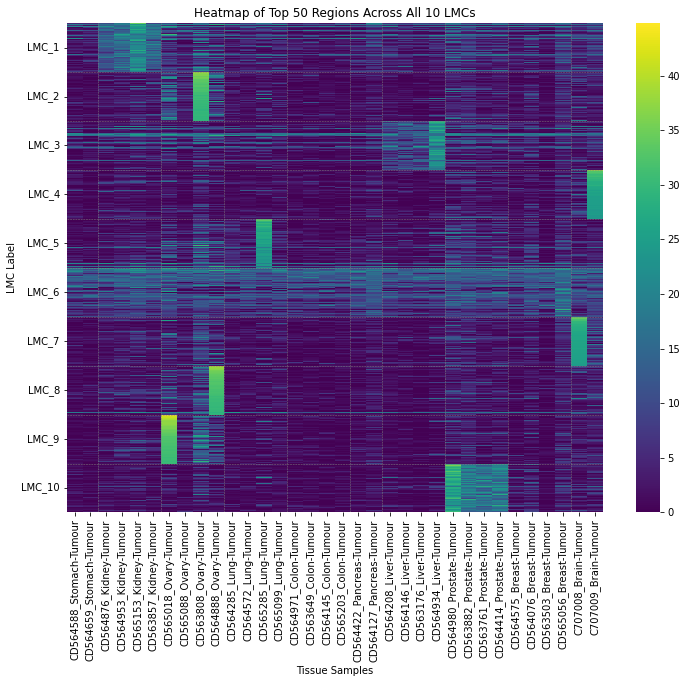

In [30]:
# Define the number of top regions to consider for each LMC
n_top_regions = 50

# Initialize a list to hold the unique top regions and a list for their corresponding LMC labels
unique_top_regions = []
lmc_labels = []

# Iterate over each LMC to collect the top regions and their labels
for i in range(n_lmc):
    regions = list(top_regions_indices_per_lmc[f'LMC_{i+1}'])
    unique_top_regions.extend(regions)
    # Extend the label list with the current LMC label, repeated for the number of regions added
    lmc_labels.extend([f'LMC_{i+1}'] * len(regions))

# Subset the healthy_df DataFrame with the unique top regions
top_regions_df = tumour_df.loc[unique_top_regions]

# Parse out the tissue names from the column headers and find the indices for tissue group changes
tissue_groups = top_regions_df.columns.str.rsplit('_', n=1).str[-1]
change_indices = [i for i in range(1, len(tissue_groups)) if tissue_groups[i] != tissue_groups[i-1]]

# Plot the heatmap
plt.figure(figsize=(12, 9))
ax = sns.heatmap(top_regions_df, cmap='viridis', yticklabels=lmc_labels, xticklabels=True)

# Set the y-ticks to be at the midpoint of the regions for each LMC
midpoints = [((i*n_top_regions) + ((i+1)*n_top_regions))/2 for i in range(n_lmc)]
ax.set_yticks(midpoints)
ax.set_yticklabels([f'LMC_{i+1}' for i in range(n_lmc)], rotation=0, ha='right')

# Add grey horizontal lines indicating the border between LMCs
for i in range(1, n_lmc):
    plt.axhline(i*n_top_regions, color='grey', linestyle='--', linewidth=0.5)

# Add vertical lines indicating the border between tissue groups
for index in change_indices:
    plt.axvline(x=index, color='grey', linestyle='--', linewidth=0.5)

plt.title(f"Heatmap of Top 50 Regions Across All {n_lmc} LMCs")
plt.xlabel('Tissue Samples')
plt.ylabel('LMC Label')
plt.show()


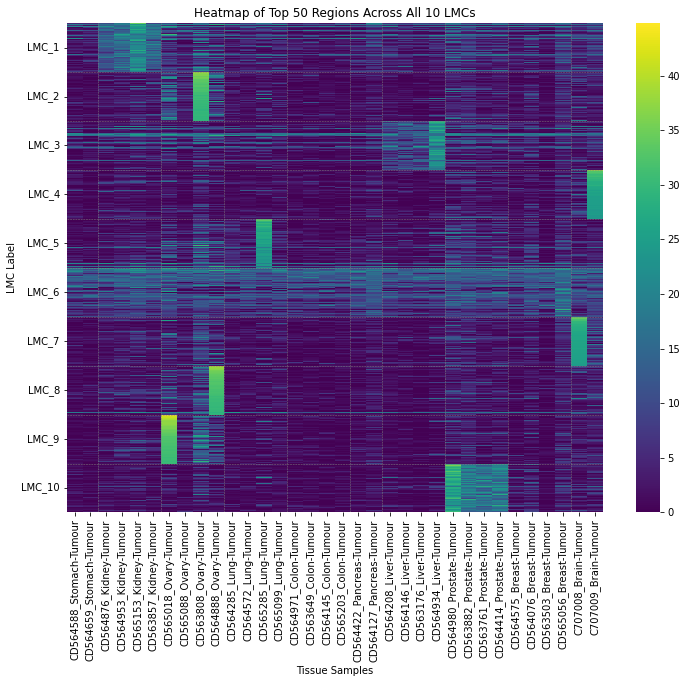

In [31]:





import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of top regions to consider for each LMC
n_top_regions = 50

# Collect the top regions for each LMC while maintaining the order and avoiding duplicates
unique_top_regions = []
for i in range(n_lmc):
    regions = list(top_regions_indices_per_lmc[f'LMC_{i+1}'])
    unique_top_regions.extend(regions)

# Subset the healthy_df DataFrame with the unique top regions
top_regions_df = tumour_df.loc[unique_top_regions]

# Parse out the tissue names from the column headers and find the indices for tissue group changes
tissue_groups = top_regions_df.columns.str.rsplit('_', n=1).str[-1]
change_indices = [i for i in range(1, len(tissue_groups)) if tissue_groups[i] != tissue_groups[i-1]]

# Plot the heatmap
plt.figure(figsize=(12, 9))
ax = sns.heatmap(top_regions_df, cmap='viridis', yticklabels=lmc_labels, xticklabels=True)

# Set the y-ticks to be at the midpoint of the regions for each LMC
midpoints = [((i*n_top_regions) + ((i+1)*n_top_regions))/2 for i in range(n_lmc)]
ax.set_yticks(midpoints)
ax.set_yticklabels([f'LMC_{i+1}' for i in range(n_lmc)], rotation=0, ha='right')

# Add grey horizontal lines indicating the border between LMCs
for i in range(1, n_lmc):
    plt.axhline(i*n_top_regions, color='grey', linestyle='--', linewidth=0.5)

# Add vertical lines indicating the border between tissue groups
for index in change_indices:
    plt.axvline(x=index, color='grey', linestyle='--', linewidth=0.5)

plt.title(f"Heatmap of Top 50 Regions Across All {n_lmc} LMCs")
plt.xlabel('Tissue Samples')
plt.ylabel('LMC Label')
plt.show()


### Repeat for mC

In [32]:
import pandas as pd
import numpy as np
import os
import collections
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy import optimize
import pickle
import time
import random
import itertools
from scipy.stats import ttest_ind, ttest_1samp
import warnings
import fastcluster
from sklearn.decomposition import NMF



local_metadata_file = "/Users/felix/Documents/DPhil/methylation/taps_tissue_atlas/tissue_atlas_v3/metadata/Atlas_V3_Metadata_New.pickle"

with open(local_metadata_file, 'rb') as f:
    project_metadata = pickle.load(f)

# Load all the variables into memory    
project_dir = project_metadata['project_dir']
atlas_dir = project_metadata['atlas_dir'] 
metadata_dir = project_metadata['metadata_dir']
gene_exp_dir = project_metadata['gene_exp_dir']
intersections_dir = project_metadata['intersections_dir']
id_tissue_map = project_metadata["id_tissue_map"]
tissue_id_map = project_metadata["tissue_id_map"]
blood_cell_types = project_metadata["blood_cell_types"]
somatic_tissue_types = project_metadata["somatic_tissue_types"]
healthy_tissue_types = project_metadata["healthy_tissue_types"]
cancer_tissue_types = project_metadata["cancer_tissue_types"]
diseased_tissue_types = project_metadata["diseased_tissue_types"]
tissues_with_tumour = project_metadata["tissues_with_tumour"]
tissue_order = project_metadata["tissue_order"]
genomic_features = project_metadata["genomic_features"]
sample_outliers = project_metadata["sample_outliers"]
# healthy_high_cov_samples = project_metadata["healthy_high_cov_samples"]
genomic_feature_colnames = project_metadata["genomic_feature_colnames"]
genomic_regions_dir = project_metadata['genomic_regions_dir']



# filename = "TAPSbeta_Atlas.all_samples.CpG.merged.filtered.TAPSbeta_hmm.healthy_high_cov_samples.test3_fixed_state.Filtered_blocks.Grail_filtering_criteria.rC.csv"
# filename = "TAPSbeta_Atlas.all_samples.CpG.merged.filtered.TAPSbeta_hmm.healthy_high_cov_samples.test3_fixed_state.Filtered_blocks.Grail_filtering_criteria.rC.csv"
# filename="TAPSbeta_Atlas.all_samples.CpG.merged.filtered.TAPSbeta_hmm.all_samples.test5_2hiddenstates_mincov3_astair_snp_filter.Filtered_blocks.large_blocks_4cpg.rC.csv"
# filename="CAPS_Atlas.all_samples.CpG.merged.filtered.CAPS_hmm.all_samples.test5_2hiddenstates_mincov3_astair_snp_filter.Filtered_blocks.large_blocks_4cpg.rC.csv"

filename="TAPSbeta_Atlas.all_samples.CpG.merged.filtered.TAPSbeta_hmm.all_samples.test7_2hiddenstates_mincov3_snp_reindex.Filtered_blocks.large_blocks_4cpg.rC.csv"


# files_dir = "/Users/felix/Documents/DPhil/methylation/taps_tissue_atlas/tissue_atlas_v3/"
files_dir = "/Users/felix/Documents/DPhil/methylation/taps_tissue_atlas/tissue_atlas_v3/example_data/"

block_atlas = pd.read_csv(files_dir + filename,
                         sep='\t',
                         # nrows=1000,
                         ).set_index('chr_start_end')



df = block_atlas.loc[:,[u for u in block_atlas.columns if 'Cirrhosis' not in u]]
df = df.loc[:,[u for u in df.columns if 'Pancreatitis' not in u]]
# df = df.rename(columns={u:u.replace("_TAPSbeta_RATE","") for u in df.columns})
# df = df.rename(columns={u:u.replace("_CAPS_RATE","") for u in df.columns})
df = df.dropna()
df = df.loc[:,[u for u in df.columns if u not in sample_outliers]]


In [33]:
# df = block_atlas.loc[:,[u for u in block_atlas.columns if 'Cirrhosis' not in u]]
# df = df.loc[:,[u for u in df.columns if 'Pancreatitis' not in u]]
# # df = df.rename(columns={u:u.replace("_TAPSbeta_RATE","") for u in df.columns})
# # df = df.rename(columns={u:u.replace("_CAPS_RATE","") for u in df.columns})
# df = df.dropna()

# # df = df.loc[:,[u for u in df.columns if u not in sample_outliers]]
# df = df.loc[:,[u for u in df.columns if u in list(id_tissue_map.keys())]]


In [34]:
healthy_df = df[[u for u in df.columns if id_tissue_map[u] in healthy_tissue_types]]
tumour_df = df[[u for u in df.columns if id_tissue_map[u] in cancer_tissue_types]]

In [35]:
healthy_df = healthy_df/100
healthy_df = 1-healthy_df 




In [36]:
## Calculate variance across rows, excluding the non-numeric columns
healthy_df['variance'] = healthy_df.var(axis=1)

topn_var = 100000
# Sort the DataFrame by 'variance' in descending order and select top n
healthy_df = healthy_df.sort_values('variance', ascending=False).head(topn_var)

# Drop the 'variance' column if it's no longer needed
healthy_df = healthy_df.drop(columns=['variance'])

In [37]:
healthy_df

CD564159_Colon  CD563663_Colon  CD563419_Colon  \
chr_start_end                                                              
chr1_44616817_44617611          0.863588        0.816647        0.891353   
chr9_127754000_127755711        0.862429        0.873286        0.909143   
chr6_35317675_35319066          0.914600        0.790500        0.877300   
chr5_177366332_177367797        0.648767        0.719000        0.832186   
chr19_6475221_6477203           0.808444        0.739630        0.843074   
...                                  ...             ...             ...   
chr20_6783830_6785145           0.805583        0.686583        0.799083   
chr1_89434310_89434852          0.221167        0.293500        0.248333   
chr4_112722109_112722385        0.559000        0.573750        0.465500   
chr6_137754093_137755597        0.341750        0.304750        0.291750   
chr7_140592897_140593484        0.393500        0.414500        0.403500   

                          CD565189_Colon  CD564242_Prostate  \
chr_start_end                                                 
chr1_44616817_44617611          0.901353           0.893235   
chr9_127754000_127755711        0.863000           0.901286   
chr6_35317675_35319066          0.911400           0.797567   
chr5_177366332_177367797        0.861163           0.898047   
chr19_6475221_6477203           0.887315           0.905019   
...                                  ...                ...   
chr20_6783830_6785145           0.736417           0.564917   
chr1_89434310_89434852          0.260000           0.177000   
chr4_112722109_112722385        0.531500           0.612250   
chr6_137754093_137755597        0.252250           0.140000   
chr7_140592897_140593484        0.395167           0.289000   

                          CD563610_Prostate  CD563685_Prostate  \
chr_start_end                                                    
chr1_44616817_44617611             0.928118           0.891824   
chr9_127754000_127755711           0.892857           0.862714   
chr6_35317675_35319066             0.831033           0.814933   
chr5_177366332_177367797           0.923814           0.901116   
chr19_6475221_6477203              0.917593           0.928000   
...                                     ...                ...   
chr20_6783830_6785145              0.599833           0.507667   
chr1_89434310_89434852             0.234833           0.182667   
chr4_112722109_112722385           0.598500           0.606750   
chr6_137754093_137755597           0.166000           0.121500   
chr7_140592897_140593484           0.433167           0.345500   

                          CD563267_Prostate  CD565017_Spleen  CD563880_Spleen  \
chr_start_end                                                                   
chr1_44616817_44617611             0.840588         0.744176         0.530529   
chr9_127754000_127755711           0.831143         0.552429         0.578571   
chr6_35317675_35319066             0.754867         0.622567         0.559700   
chr5_177366332_177367797           0.867000         0.626186         0.687930   
chr19_6475221_6477203              0.821185         0.702074         0.648741   
...                                     ...              ...              ...   
chr20_6783830_6785145              0.472000         0.335333         0.449333   
chr1_89434310_89434852             0.247500         0.253000         0.345000   
chr4_112722109_112722385           0.548500         0.350500         0.394000   
chr6_137754093_137755597           0.235000         0.357250         0.480750   
chr7_140592897_140593484           0.379167         0.204667         0.188000   

                          ...  UKVAC-003-6_Monocytes  UKVAC-001-5_Monocytes  \
chr_start_end             ...                                                 
chr1_44616817_44617611    ...               0.076706               0.064529   
chr9_127754000_127755711  ...               0.046286               

In [38]:

# Assuming 'methylation_df' is your DataFrame

n_lmc = 22
nmf = NMF(n_components=n_lmc, init='random', random_state=0)
lmc = nmf.fit_transform(healthy_df)







/Users/felix/opt/anaconda3/envs/local_ds/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [39]:
ranked_regions = np.argsort(-lmc, axis=0)  # Negate to sort in descending order


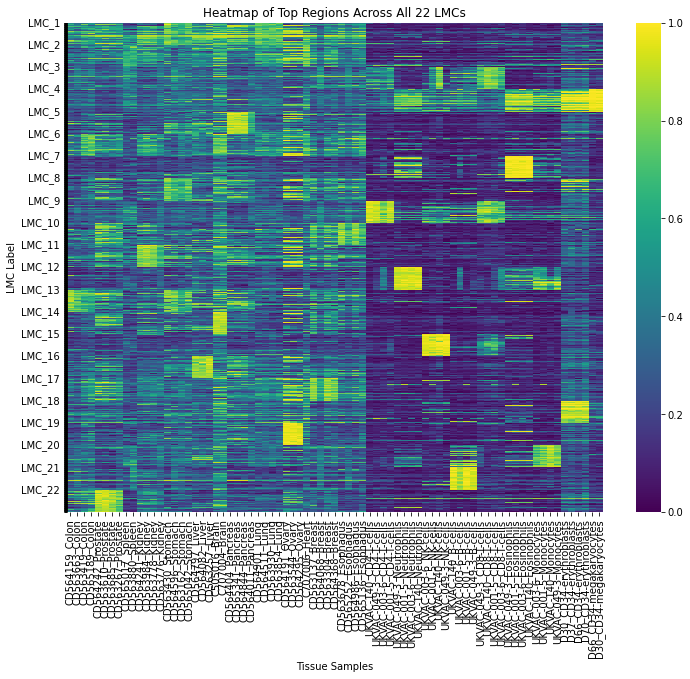

In [40]:

# Assuming that 'healthy_df' has an index or a column with the genomic region names
# and 'ranked_regions' is already computed as before

n_top_regions = 100
top_regions_indices_per_lmc = pd.DataFrame(index=range(n_top_regions))
top_regions_weights_per_lmc = pd.DataFrame(index=range(n_top_regions))

# Retrieve the names of the genomic regions from the DataFrame index or a specific column
genomic_region_names = healthy_df.index  # Replace with healthy_df['region_column_name'] if using a column

for i in range(n_lmc):
    top_indices = ranked_regions[:n_top_regions, i]  # Top regions for the ith LMC
    top_weights = lmc[top_indices, i]
    top_region_names = genomic_region_names[top_indices]  # Get the names of the top regions
    
    # Store the names and weights in separate DataFrames for the ith LMC
    top_regions_indices_per_lmc[f'LMC_{i+1}'] = top_region_names
    top_regions_weights_per_lmc[f'LMC_{i+1}'] = top_weights



# Initialize a list to hold the unique top regions and a list for their corresponding LMC labels
unique_top_regions = []
lmc_labels = []

# Iterate over each LMC to collect the top regions and their labels
for i in range(n_lmc):
    regions = list(top_regions_indices_per_lmc[f'LMC_{i+1}'])
    unique_top_regions.extend(regions)
    # Extend the label list with the current LMC label, repeated for the number of regions added
    lmc_labels.extend([f'LMC_{i+1}'] * len(regions))

# Now subset the healthy_df DataFrame with the unique top regions
top_regions_df = healthy_df.loc[unique_top_regions]

# Plot the heatmap
plt.figure(figsize=(12, 9))
ax = sns.heatmap(top_regions_df, cmap='viridis', yticklabels=lmc_labels, xticklabels=True)
plt.title(f"Heatmap of Top Regions Across All {n_lmc} LMCs")
plt.xlabel('Tissue Samples')
plt.ylabel('LMC Label')

# Modify the yticks to only show one label per LMC
yticks = ax.get_yticks()
# Set every nth label to be visible (n = number of regions per LMC), the rest will be set to empty string
ax.set_yticklabels(['' if (idx % n_top_regions) else label for idx, label in enumerate(lmc_labels)])

plt.show()


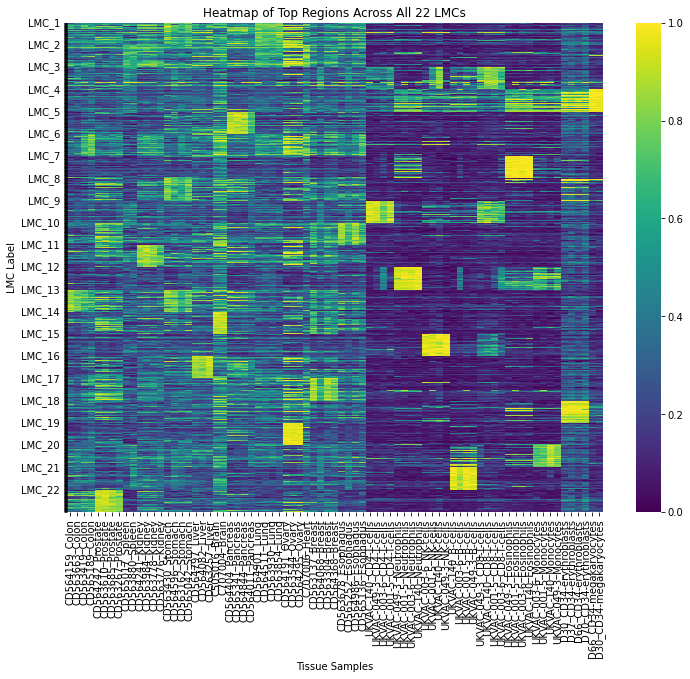

In [41]:
ranked_regions = np.argsort(-lmc, axis=0)  # Negate to sort in descending order


# Assuming that 'healthy_df' has an index or a column with the genomic region names
# and 'ranked_regions' is already computed as before

n_top_regions = 50
top_regions_indices_per_lmc = pd.DataFrame(index=range(n_top_regions))
top_regions_weights_per_lmc = pd.DataFrame(index=range(n_top_regions))

# Retrieve the names of the genomic regions from the DataFrame index or a specific column
genomic_region_names = healthy_df.index  # Replace with healthy_df['region_column_name'] if using a column

for i in range(n_lmc):
    top_indices = ranked_regions[:n_top_regions, i]  # Top regions for the ith LMC
    top_weights = lmc[top_indices, i]
    top_region_names = genomic_region_names[top_indices]  # Get the names of the top regions
    
    # Store the names and weights in separate DataFrames for the ith LMC
    top_regions_indices_per_lmc[f'LMC_{i+1}'] = top_region_names
    top_regions_weights_per_lmc[f'LMC_{i+1}'] = top_weights


# Define the number of top regions to consider for each LMC
n_top_regions = 50

# Initialize a list to hold the unique top regions and a list for their corresponding LMC labels
unique_top_regions = []
lmc_labels = []

# Iterate over each LMC to collect the top regions and their labels
for i in range(n_lmc):
    regions = list(top_regions_indices_per_lmc[f'LMC_{i+1}'])
    unique_top_regions.extend(regions)
    # Extend the label list with the current LMC label, repeated for the number of regions added
    lmc_labels.extend([f'LMC_{i+1}'] * len(regions))

# Now subset the healthy_df DataFrame with the unique top regions
top_regions_df = healthy_df.loc[unique_top_regions]

# Plot the heatmap
plt.figure(figsize=(12, 9))
ax = sns.heatmap(top_regions_df, cmap='viridis', yticklabels=lmc_labels, xticklabels=True)
plt.title(f"Heatmap of Top Regions Across All {n_lmc} LMCs")
plt.xlabel('Tissue Samples')
plt.ylabel('LMC Label')

# Modify the yticks to only show one label per LMC
yticks = ax.get_yticks()
# Set every nth label to be visible (n = number of regions per LMC), the rest will be set to empty string
ax.set_yticklabels(['' if (idx % n_top_regions) else label for idx, label in enumerate(lmc_labels)])

plt.show()


In [42]:
# Calculate correlations between original columns and LMCs
lmc_df = pd.DataFrame(lmc, index=healthy_df.index)
correlation_matrix = pd.DataFrame(np.corrcoef(healthy_df.T, lmc_df.T)[:healthy_df.shape[1], healthy_df.shape[1]:],
                                  index=healthy_df.columns, columns=[f"LMC_{i+1}" for i in range(n_lmc)])




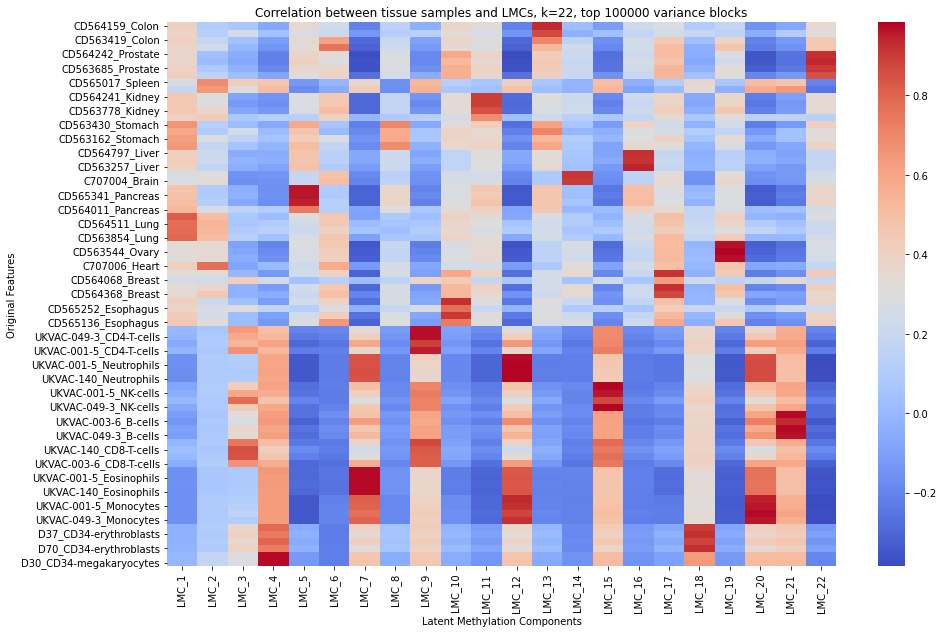

In [44]:
# Plotting the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, top {topn_var} variance blocks")
# plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, all {len(healthy_df)} blocks")
plt.ylabel("Original Features")
plt.xlabel("Latent Methylation Components")
plt.show()

In [ ]:

                
                
custom_lmc_order = [13,6,22,11,8,16,14,5,1,19,2,17,10,9,12,15,21,3,7,20,18,4]
lmc_string_order = [f"LMC_{u}" for u in custom_lmc_order]
[u for u in correlation_matrix.columns if u not in lmc_string_order]

tissue_labels = [id_tissue_map[col] for col in healthy_df.columns]

# Plotting the heatmap
plt.figure(figsize=(15, 10))
# sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
sns.heatmap(correlation_matrix[lmc_string_order],
            annot=False,
            cmap='coolwarm',
            yticklabels=tissue_labels,
           cbar_kws={'shrink':cbar_shrink})


unique_tissue_names = []
tick_positions = []
for k,tissue in enumerate(tissue_xticklabels):
    if tissue in unique_tissue_names:
        pass
    else:

        if tissue=="Kidney":
            tick_positions.append(k+1)
            unique_tissue_names.append(tissue)   
        else:
            tick_positions.append(k)
            unique_tissue_names.append(tissue)

# plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, top {topn_var} variance blocks")
plt.title(f"Pearson Correlation between tissue samples and LMCs")
# plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, all {len(healthy_df)} blocks")
# plt.ylabel("Original Features")
# plt.xlabel("Latent Methylation Components")
# plt.show()
figure_savedir = "/Users/felix/Documents/DPhil/thesis/thesis_figures/local_nmf/"
# plt.savefig(figure_savedir + "TAPSbeta.healthy_samples_NMF.correlation_LMCs.heatmap.png")

In [108]:
tissue_labels = [id_tissue_map[col] for col in healthy_df.columns]

unique_tissue_names = []
tick_positions = []
for k,tissue in enumerate(tissue_labels):
    if tissue in unique_tissue_names:
        pass
    else:
#         if tissue=="Breast":
#             tick_positions.append(k+1)
#             unique_tissue_names.append(tissue)

#         else:
#             tick_positions.append(k)
#             unique_tissue_names.append(tissue)

        tick_positions.append(k)
        unique_tissue_names.append(tissue)


0
4
8
10
14
18
21
23
27
31
34
35
39
43
47
51
55
59
63
67
71
75


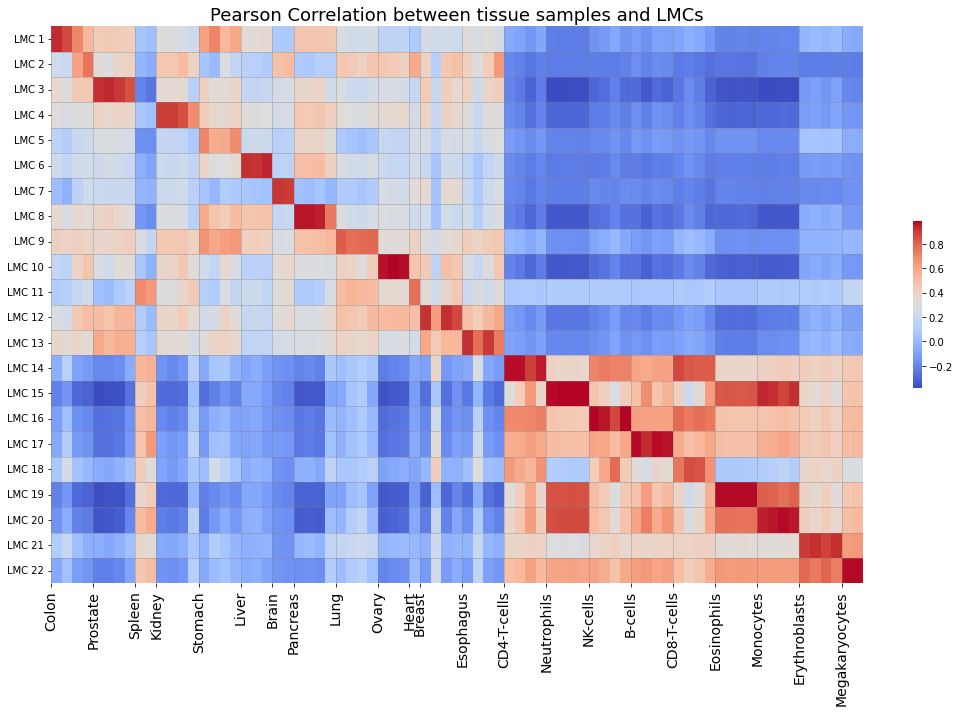

In [110]:
custom_lmc_order = [13,6,22,11,8,16,14,5,1,19,2,17,10,9,12,15,21,3,7,20,18,4]
lmc_string_order = [f"LMC_{u}" for u in custom_lmc_order]
[u for u in correlation_matrix.columns if u not in lmc_string_order]

tissue_labels = [id_tissue_map[col] for col in healthy_df.columns]

# Plotting the heatmap
fig,ax = plt.subplots(figsize=(15, 10))
# sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
sns.heatmap(correlation_matrix[lmc_string_order].T,
            annot=False,
            cmap='coolwarm',
#             yticklabels=tissue_labels,
           cbar_kws={'shrink':cbar_shrink},
           ax=ax)

ax.set_xticks(tick_positions)
ax.set_xticklabels(unique_tissue_names, rotation=90,fontsize=14)


ax.set_yticklabels([f'LMC {i+1}' for i in range(n_lmc)], rotation=0, ha='right')

# # Set the y-ticks to be at the midpoint of the regions for each LMC
# midpoints = [((i*n_top_regions) + ((i+1)*n_top_regions))/2 for i in range(n_lmc)]
# ax.set_yticks(midpoints)
# ax.set_yticklabels([f'LMC {i+1}' for i in range(n_lmc)], rotation=0, ha='right')

# # Add grey horizontal lines indicating the border between LMCs
# for i in range(1, n_lmc):
#     plt.axhline(i*n_top_regions, color='grey', linestyle='--', linewidth=0.5)

# # Add vertical lines indicating the border between tissue groups
# for index in change_indices:
#     plt.axvline(x=index, color='grey', linestyle='--', linewidth=0.5)

# Add grey horizontal lines indicating the border between LMCs
for i in range(1, n_lmc):
    plt.axhline(i, color='grey', linestyle='--', linewidth=0.5)

# Add vertical lines indicating the border between tissue groups
# for index in change_indices:
for index in tick_positions:
    print(index)
    plt.axvline(x=index, color='grey', linestyle='--', linewidth=0.5)


# plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, top {topn_var} variance blocks")
ax.set_title(f"Pearson Correlation between tissue samples and LMCs",fontsize=18)
# plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, all {len(healthy_df)} blocks")
# plt.ylabel("Original Features")
# plt.xlabel("Latent Methylation Components")
# plt.show()
plt.tight_layout()
figure_savedir = "/Users/felix/Documents/DPhil/thesis/thesis_figures/local_nmf/"
# plt.savefig(figure_savedir + "TAPSbeta.healthy_samples_NMF.correlation_LMCs.heatmap.relabelled.rotated.thesis_clean.png")


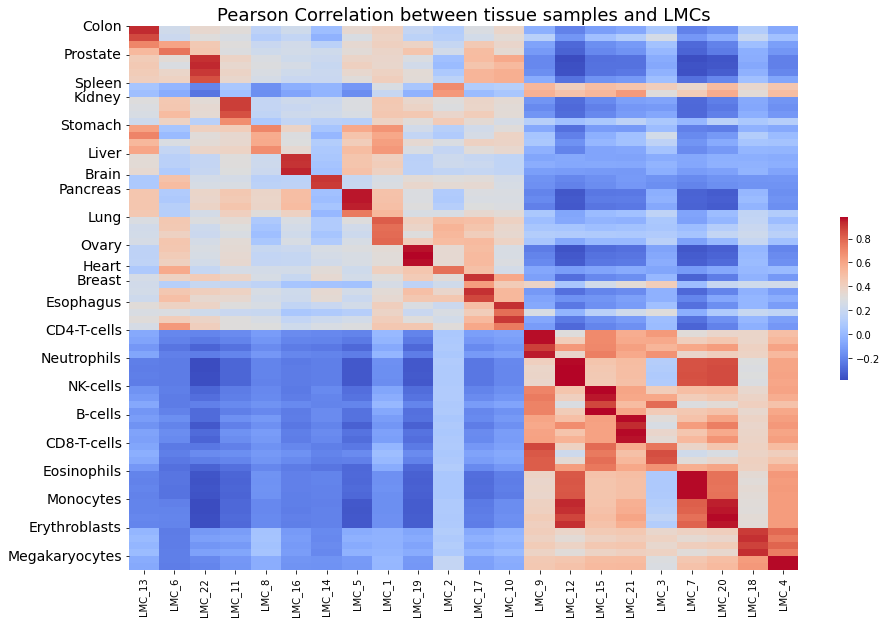

In [78]:
custom_lmc_order = [13,6,22,11,8,16,14,5,1,19,2,17,10,9,12,15,21,3,7,20,18,4]
lmc_string_order = [f"LMC_{u}" for u in custom_lmc_order]
[u for u in correlation_matrix.columns if u not in lmc_string_order]

tissue_labels = [id_tissue_map[col] for col in healthy_df.columns]

# Plotting the heatmap
fig,ax = plt.subplots(figsize=(15, 10))
# sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
sns.heatmap(correlation_matrix[lmc_string_order],
            annot=False,
            cmap='coolwarm',
#             yticklabels=tissue_labels,
           cbar_kws={'shrink':cbar_shrink},
           ax=ax)

ax.set_yticks(tick_positions)
ax.set_yticklabels(unique_tissue_names, rotation=0,fontsize=14)





# plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, top {topn_var} variance blocks")
ax.set_title(f"Pearson Correlation between tissue samples and LMCs",fontsize=18)
# plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, all {len(healthy_df)} blocks")
# plt.ylabel("Original Features")
# plt.xlabel("Latent Methylation Components")
# plt.show()

figure_savedir = "/Users/felix/Documents/DPhil/thesis/thesis_figures/local_nmf/"
plt.savefig(figure_savedir + "TAPSbeta.healthy_samples_NMF.correlation_LMCs.heatmap.relabelled.thesis_clean.png")

### original figure (do not change)

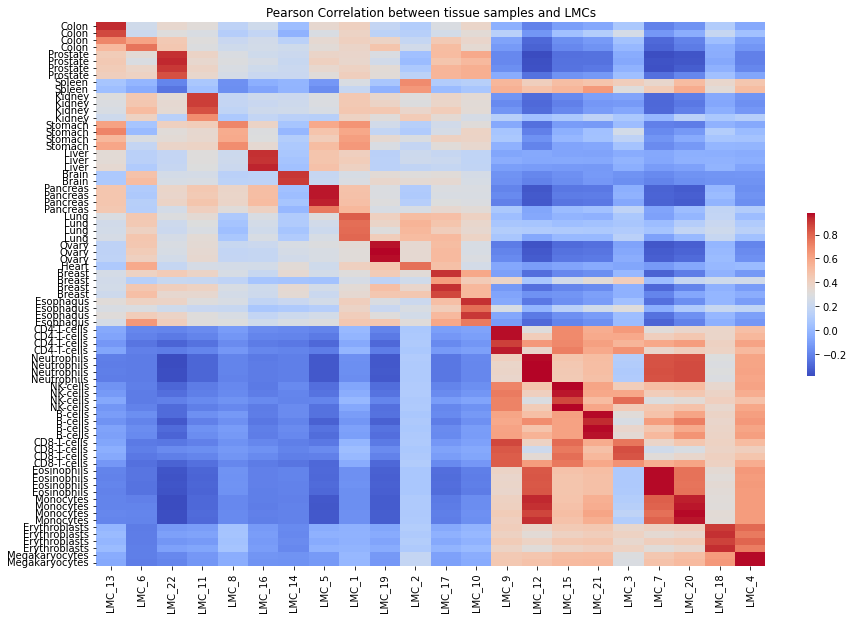

In [46]:
custom_lmc_order = [13,6,22,11,8,16,14,5,1,19,2,17,10,9,12,15,21,3,7,20,18,4]
lmc_string_order = [f"LMC_{u}" for u in custom_lmc_order]
[u for u in correlation_matrix.columns if u not in lmc_string_order]

tissue_labels = [id_tissue_map[col] for col in healthy_df.columns]

# Plotting the heatmap
plt.figure(figsize=(15, 10))
# sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
sns.heatmap(correlation_matrix[lmc_string_order],
            annot=False,
            cmap='coolwarm',
            yticklabels=tissue_labels,
           cbar_kws={'shrink':cbar_shrink})


# plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, top {topn_var} variance blocks")
plt.title(f"Pearson Correlation between tissue samples and LMCs")
# plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, all {len(healthy_df)} blocks")
# plt.ylabel("Original Features")
# plt.xlabel("Latent Methylation Components")
# plt.show()
figure_savedir = "/Users/felix/Documents/DPhil/thesis/thesis_figures/local_nmf/"
# plt.savefig(figure_savedir + "TAPSbeta.healthy_samples_NMF.correlation_LMCs.heatmap.png")

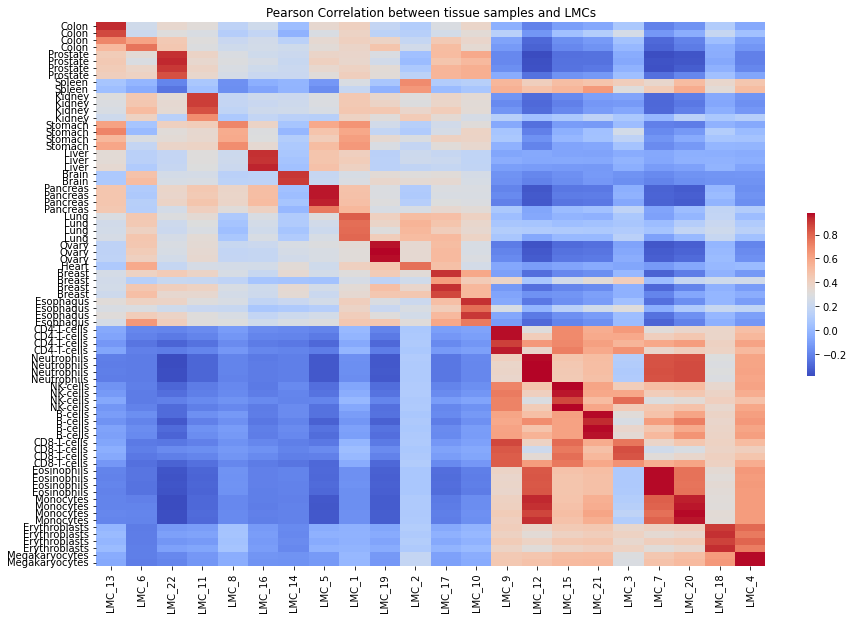

In [142]:
custom_lmc_order = [13,6,22,11,8,16,14,5,1,19,2,17,10,9,12,15,21,3,7,20,18,4]
lmc_string_order = [f"LMC_{u}" for u in custom_lmc_order]
[u for u in correlation_matrix.columns if u not in lmc_string_order]

tissue_labels = [id_tissue_map[col] for col in healthy_df.columns]

# Plotting the heatmap
plt.figure(figsize=(15, 10))
# sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
sns.heatmap(correlation_matrix[lmc_string_order],
            annot=False,
            cmap='coolwarm',
            yticklabels=tissue_labels,
           cbar_kws={'shrink':cbar_shrink})


# plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, top {topn_var} variance blocks")
plt.title(f"Pearson Correlation between tissue samples and LMCs")
# plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, all {len(healthy_df)} blocks")
# plt.ylabel("Original Features")
# plt.xlabel("Latent Methylation Components")
# plt.show()
figure_savedir = "/Users/felix/Documents/DPhil/thesis/thesis_figures/local_nmf/"
# plt.savefig(figure_savedir + "TAPSbeta.healthy_samples_NMF.correlation_LMCs.heatmap.png")

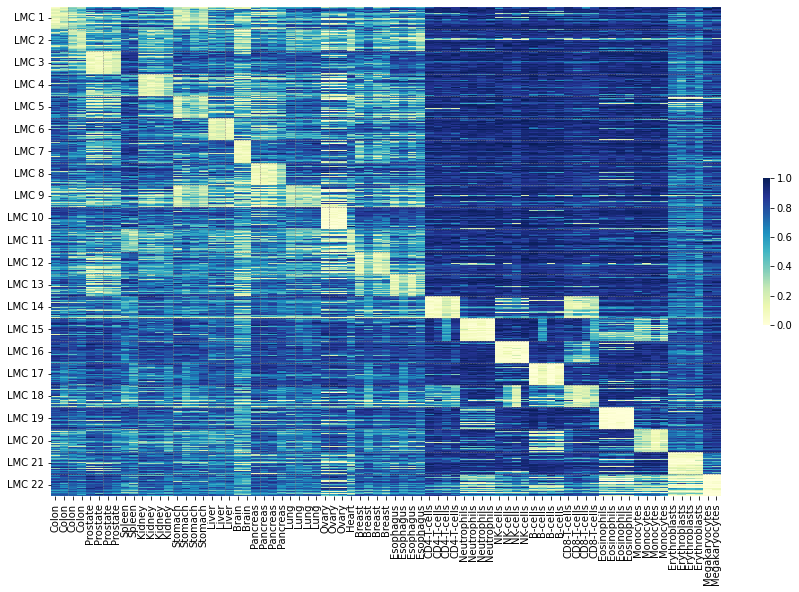

In [81]:
ranked_regions = np.argsort(-lmc, axis=0)  # Negate to sort in descending order


# Assuming that 'healthy_df' has an index or a column with the genomic region names
# and 'ranked_regions' is already computed as before

n_top_regions = 50
top_regions_indices_per_lmc = pd.DataFrame(index=range(n_top_regions))
top_regions_weights_per_lmc = pd.DataFrame(index=range(n_top_regions))

# Retrieve the names of the genomic regions from the DataFrame index or a specific column
genomic_region_names = healthy_df.index  # Replace with healthy_df['region_column_name'] if using a column

for i in range(n_lmc):
    top_indices = ranked_regions[:n_top_regions, i]  # Top regions for the ith LMC
    top_weights = lmc[top_indices, i]
    top_region_names = genomic_region_names[top_indices]  # Get the names of the top regions
    
    # Store the names and weights in separate DataFrames for the ith LMC
    top_regions_indices_per_lmc[f'LMC_{i+1}'] = top_region_names
    top_regions_weights_per_lmc[f'LMC_{i+1}'] = top_weights


# Define the number of top regions to consider for each LMC
n_top_regions = 50

# Initialize a list to hold the unique top regions and a list for their corresponding LMC labels
unique_top_regions = []
lmc_labels = []

# Iterate over each LMC to collect the top regions and their labels
for i in custom_lmc_order:
    regions = list(top_regions_indices_per_lmc[f'LMC_{i}'])
    unique_top_regions.extend(regions)
    # Extend the label list with the current LMC label, repeated for the number of regions added
    lmc_labels.extend([f'LMC_{i+1}'] * len(regions))

# Now subset the healthy_df DataFrame with the unique top regions
top_regions_df = healthy_df.loc[unique_top_regions]

# Plot the heatmap
plt.figure(figsize=(15, 9))
ax = sns.heatmap(1-top_regions_df, cmap='YlGnBu', yticklabels=lmc_labels, 
                 xticklabels=tissue_labels,
                cbar_kws={'shrink':cbar_shrink})
# plt.title(f"Heatmap of Top Regions Across All {n_lmc} LMCs")
# plt.xlabel('Tissue Samples')
# plt.ylabel('LMC Label')
plt.ylabel('')


# Set the y-ticks to be at the midpoint of the regions for each LMC
midpoints = [((i*n_top_regions) + ((i+1)*n_top_regions))/2 for i in range(n_lmc)]
ax.set_yticks(midpoints)
ax.set_yticklabels([f'LMC {i+1}' for i in range(n_lmc)], rotation=0, ha='right')

# Add grey horizontal lines indicating the border between LMCs
for i in range(1, n_lmc):
    plt.axhline(i*n_top_regions, color='grey', linestyle='--', linewidth=0.5)

# Add vertical lines indicating the border between tissue groups
for index in change_indices:
    plt.axvline(x=index, color='grey', linestyle='--', linewidth=0.5)


# # Modify the yticks to only show one label per LMC
# yticks = ax.get_yticks()
# # Set every nth label to be visible (n = number of regions per LMC), the rest will be set to empty string
# ax.set_yticklabels(['' if (idx % n_top_regions) else label for idx, label in enumerate(lmc_labels)])

# plt.show()
figure_savedir = "/Users/felix/Documents/DPhil/thesis/thesis_figures/local_nmf/"
plt.savefig(figure_savedir + "TAPSbeta.healthy_samples_NMF.meth_values.heatmap.inverted.thesis_clean.png")


In [84]:
top_regions_df

CD564159_Colon  CD563663_Colon  CD563419_Colon  \
chr_start_end                                                               
chr20_419673_419767              0.937000        0.788000        0.778200   
chr7_926573_926628               0.947800        0.868200        0.660000   
chr19_48613009_48613351          0.907933        0.837733        0.765333   
chr7_926489_926573               0.903250        0.786000        0.595750   
chr17_79925879_79925908          0.871250        0.713750        0.750000   
...                                   ...             ...             ...   
chr12_54414564_54414672          0.537571        0.433857        0.420429   
chr6_111848510_111848755         0.223750        0.205750        0.254750   
chr10_111114013_111115027        0.289800        0.354000        0.328933   
chr2_148542886_148543428         0.279900        0.230000        0.251800   
chr3_43405752_43406760           0.161417        0.231750        0.344833   

                           CD565189_Colon  CD564242_Prostate  \
chr_start_end                                                  
chr20_419673_419767              0.604200           0.646200   
chr7_926573_926628               0.721800           0.435600   
chr19_48613009_48613351          0.664800           0.613267   
chr7_926489_926573               0.685750           0.312750   
chr17_79925879_79925908          0.657750           0.438000   
...                                   ...                ...   
chr12_54414564_54414672          0.491429           0.335143   
chr6_111848510_111848755         0.456750           0.154250   
chr10_111114013_111115027        0.335800           0.276467   
chr2_148542886_148543428         0.256800           0.250500   
chr3_43405752_43406760           0.449750           0.131083   

                           CD563610_Prostate  CD563685_Prostate  \
chr_start_end                                                     
chr20_419673_419767                 0.333800           0.429800   
chr7_926573_926628                  0.385000           0.460400   
chr19_48613009_48613351             0.580667           0.487333   
chr7_926489_926573                  0.198500           0.273000   
chr17_79925879_79925908             0.566750           0.655250   
...                                      ...                ...   
chr12_54414564_54414672             0.208857           0.281714   
chr6_111848510_111848755            0.050000           0.104000   
chr10_111114013_111115027           0.280067           0.304600   
chr2_148542886_148543428            0.257000           0.225500   
chr3_43405752_43406760              0.232833           0.249083   

                           CD563267_Prostate  CD565017_Spleen  \
chr_start_end                                                   
chr20_419673_419767                 0.610800         0.316000   
chr7_926573_926628                  0.268400         0.547200   
chr19_48613009_48613351             0.521533         0.300733   
chr7_926489_926573                  0.203000         0.346750   
chr17_79925879_79925908             0.518250         0.230250   
...                                      ...              ...   
chr12_54414564_54414672             0.289286         0.254857   
chr6_111848510_111848755            0.099000         0.115250   
chr10_111114013_111115027           0.388133         0.605867   
chr2_148542886_148543428            0.248600         0.194300   
chr3_43405752_43406760              0.344000         0.438250   

                           CD563880_Spleen  ...  UKVAC-003-6_Monocytes  \
chr_start_end                               ...                          
chr20_419673_419767               0.331600  ...               0.060000   
chr7_926573_926628                0.525800  ...               0.066600   
chr19_48613009_48613351           0.366733  ...               0.234667   
chr7_926489_926573                0.451500  ...               0.133250   
chr17_79925879_79925908       

0
4
8
10
14
18
21
23
27
31
34
35
39
43
47
51
55
59
63
67
71
75


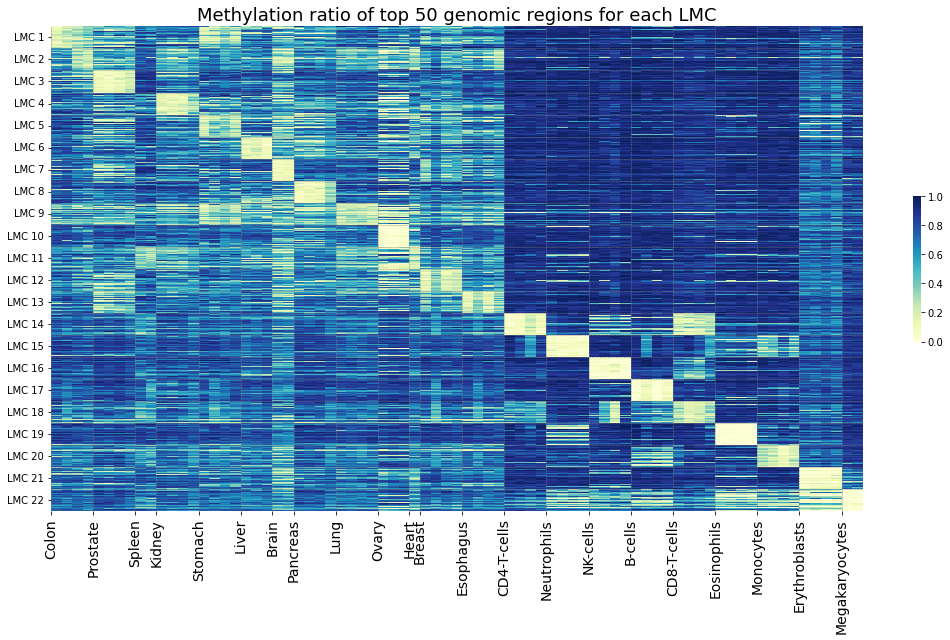

In [102]:
ranked_regions = np.argsort(-lmc, axis=0)  # Negate to sort in descending order


# Assuming that 'healthy_df' has an index or a column with the genomic region names
# and 'ranked_regions' is already computed as before

n_top_regions = 50
top_regions_indices_per_lmc = pd.DataFrame(index=range(n_top_regions))
top_regions_weights_per_lmc = pd.DataFrame(index=range(n_top_regions))

# Retrieve the names of the genomic regions from the DataFrame index or a specific column
genomic_region_names = healthy_df.index  # Replace with healthy_df['region_column_name'] if using a column

for i in range(n_lmc):
    top_indices = ranked_regions[:n_top_regions, i]  # Top regions for the ith LMC
    top_weights = lmc[top_indices, i]
    top_region_names = genomic_region_names[top_indices]  # Get the names of the top regions
    
    # Store the names and weights in separate DataFrames for the ith LMC
    top_regions_indices_per_lmc[f'LMC_{i+1}'] = top_region_names
    top_regions_weights_per_lmc[f'LMC_{i+1}'] = top_weights


# Define the number of top regions to consider for each LMC
n_top_regions = 50

# Initialize a list to hold the unique top regions and a list for their corresponding LMC labels
unique_top_regions = []
lmc_labels = []

# Iterate over each LMC to collect the top regions and their labels
for i in custom_lmc_order:
    regions = list(top_regions_indices_per_lmc[f'LMC_{i}'])
    unique_top_regions.extend(regions)
    # Extend the label list with the current LMC label, repeated for the number of regions added
    lmc_labels.extend([f'LMC_{i+1}'] * len(regions))

# Now subset the healthy_df DataFrame with the unique top regions
top_regions_df = 1- healthy_df.loc[unique_top_regions]

# Plot the heatmap
plt.figure(figsize=(15, 9))
ax = sns.heatmap(top_regions_df, cmap='YlGnBu', yticklabels=lmc_labels, 
                 xticklabels=tissue_labels,
                cbar_kws={'shrink':cbar_shrink})
# plt.title(f"Heatmap of Top Regions Across All {n_lmc} LMCs")
# plt.xlabel('Tissue Samples')
# plt.ylabel('LMC Label')
plt.ylabel('')

ax.set_xticks(tick_positions)
ax.set_xticklabels(unique_tissue_names, rotation=90,fontsize=14)
# Set the y-ticks to be at the midpoint of the regions for each LMC
midpoints = [((i*n_top_regions) + ((i+1)*n_top_regions))/2 for i in range(n_lmc)]
ax.set_yticks(midpoints)
ax.set_yticklabels([f'LMC {i+1}' for i in range(n_lmc)], rotation=0, ha='right')
ax.set_title('Methylation ratio of top 50 genomic regions for each LMC',fontsize=18)
# Add grey horizontal lines indicating the border between LMCs
for i in range(1, n_lmc):
    plt.axhline(i*n_top_regions, color='grey', linestyle='--', linewidth=0.5)

# Add vertical lines indicating the border between tissue groups
# for index in change_indices:
for index in tick_positions:
    print(index)
    plt.axvline(x=index, color='grey', linestyle='--', linewidth=0.5)


# # Modify the yticks to only show one label per LMC
# yticks = ax.get_yticks()
# # Set every nth label to be visible (n = number of regions per LMC), the rest will be set to empty string
# ax.set_yticklabels(['' if (idx % n_top_regions) else label for idx, label in enumerate(lmc_labels)])

# plt.show()
plt.tight_layout()
figure_savedir = "/Users/felix/Documents/DPhil/thesis/thesis_figures/local_nmf/"
plt.savefig(figure_savedir + "TAPSbeta.healthy_samples_NMF.meth_values.heatmap.inverted.relabelled.thesis_clean.png")
# plt.savefig(figure_savedir + "TAPSbeta.healthy_samples_NMF.meth_values.heatmap.png")


In [91]:
tick_positions

[0,
 4,
 8,
 10,
 14,
 18,
 21,
 23,
 27,
 31,
 34,
 36,
 39,
 43,
 47,
 51,
 55,
 59,
 63,
 67,
 71,
 75]

In [90]:
change_indices

[2, 6, 10, 14, 18, 20, 24, 28, 32]

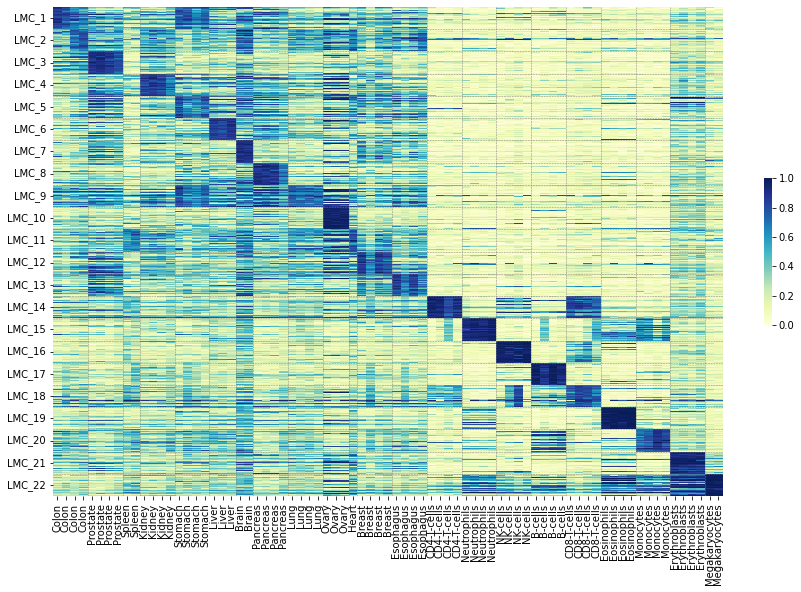

In [143]:
ranked_regions = np.argsort(-lmc, axis=0)  # Negate to sort in descending order


# Assuming that 'healthy_df' has an index or a column with the genomic region names
# and 'ranked_regions' is already computed as before

n_top_regions = 50
top_regions_indices_per_lmc = pd.DataFrame(index=range(n_top_regions))
top_regions_weights_per_lmc = pd.DataFrame(index=range(n_top_regions))

# Retrieve the names of the genomic regions from the DataFrame index or a specific column
genomic_region_names = healthy_df.index  # Replace with healthy_df['region_column_name'] if using a column

for i in range(n_lmc):
    top_indices = ranked_regions[:n_top_regions, i]  # Top regions for the ith LMC
    top_weights = lmc[top_indices, i]
    top_region_names = genomic_region_names[top_indices]  # Get the names of the top regions
    
    # Store the names and weights in separate DataFrames for the ith LMC
    top_regions_indices_per_lmc[f'LMC_{i+1}'] = top_region_names
    top_regions_weights_per_lmc[f'LMC_{i+1}'] = top_weights


# Define the number of top regions to consider for each LMC
n_top_regions = 50

# Initialize a list to hold the unique top regions and a list for their corresponding LMC labels
unique_top_regions = []
lmc_labels = []

# Iterate over each LMC to collect the top regions and their labels
for i in custom_lmc_order:
    regions = list(top_regions_indices_per_lmc[f'LMC_{i}'])
    unique_top_regions.extend(regions)
    # Extend the label list with the current LMC label, repeated for the number of regions added
    lmc_labels.extend([f'LMC_{i+1}'] * len(regions))

# Now subset the healthy_df DataFrame with the unique top regions
top_regions_df = healthy_df.loc[unique_top_regions]

# Plot the heatmap
plt.figure(figsize=(15, 9))
ax = sns.heatmap(top_regions_df, cmap='YlGnBu', yticklabels=lmc_labels, 
                 xticklabels=tissue_labels,
                cbar_kws={'shrink':cbar_shrink})
# plt.title(f"Heatmap of Top Regions Across All {n_lmc} LMCs")
# plt.xlabel('Tissue Samples')
# plt.ylabel('LMC Label')
plt.ylabel('')


# Set the y-ticks to be at the midpoint of the regions for each LMC
midpoints = [((i*n_top_regions) + ((i+1)*n_top_regions))/2 for i in range(n_lmc)]
ax.set_yticks(midpoints)
ax.set_yticklabels([f'LMC_{i+1}' for i in range(n_lmc)], rotation=0, ha='right')

# Add grey horizontal lines indicating the border between LMCs
for i in range(1, n_lmc):
    plt.axhline(i*n_top_regions, color='grey', linestyle='--', linewidth=0.5)

# Add vertical lines indicating the border between tissue groups
for index in change_indices:
    plt.axvline(x=index, color='grey', linestyle='--', linewidth=0.5)


# # Modify the yticks to only show one label per LMC
# yticks = ax.get_yticks()
# # Set every nth label to be visible (n = number of regions per LMC), the rest will be set to empty string
# ax.set_yticklabels(['' if (idx % n_top_regions) else label for idx, label in enumerate(lmc_labels)])

# plt.show()
figure_savedir = "/Users/felix/Documents/DPhil/thesis/thesis_figures/local_nmf/"
# plt.savefig(figure_savedir + "TAPSbeta.healthy_samples_NMF.meth_values.heatmap.png")


### Tumour

In [103]:
## Calculate variance across rows, excluding the non-numeric columns
tumour_df['variance'] = tumour_df.var(axis=1)

topn_var = 100000
# Sort the DataFrame by 'variance' in descending order and select top n
tumour_df = tumour_df.sort_values('variance', ascending=False).head(topn_var)

# Drop the 'variance' column if it's no longer needed
tumour_df = tumour_df.drop(columns=['variance'])

<ipython-input-103-8309cc8526f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumour_df['variance'] = tumour_df.var(axis=1)


In [104]:
tumour_df = tumour_df/100
tumour_df = 1-tumour_df 

In [105]:

# Assuming 'methylation_df' is your DataFrame

# Perform NMF to extract 20 LMCs

n_lmc = 10
# n_lmc = 2
nmf = NMF(n_components=n_lmc, init='random', random_state=0)
lmc = nmf.fit_transform(tumour_df)


/Users/felix/opt/anaconda3/envs/local_ds/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [106]:
tumour_df

CD564588_Stomach-Tumour  CD564659_Stomach-Tumour  \
chr_start_end                                                                
chr13_39006670_39006998                  0.116333                 0.765500   
chr2_241891481_241891575                 0.473375                 0.186125   
chr10_96370138_96370231                  0.560000                 0.593750   
chr17_75640072_75640169                  0.652000                 0.508167   
chr3_169822256_169822290                 0.555750                 0.704500   
...                                           ...                      ...   
chr8_1265950_1266965                     0.163056                 0.277722   
chr8_49492931_49493515                   0.268800                 0.318400   
chr5_33006125_33008024                   0.137778                 0.208000   
chr4_162303302_162304684                 0.402200                 0.259000   
chr11_84793226_84797628                  0.378838                 0.268541   

                          CD564876_Kidney-Tumour  CD564953_Kidney-Tumour  \
chr_start_end                                                              
chr13_39006670_39006998                 0.056167                0.067667   
chr2_241891481_241891575                0.066875                0.052750   
chr10_96370138_96370231                 0.133500                0.050500   
chr17_75640072_75640169                 0.026667                0.033333   
chr3_169822256_169822290                0.138250                0.133750   
...                                          ...                     ...   
chr8_1265950_1266965                    0.224667                0.196278   
chr8_49492931_49493515                  0.368600                0.194000   
chr5_33006125_33008024                  0.160444                0.104222   
chr4_162303302_162304684                0.511400                0.307400   
chr11_84793226_84797628                 0.193162                0.141892   

                          CD565153_Kidney-Tumour  CD563857_Kidney-Tumour  \
chr_start_end                                                              
chr13_39006670_39006998                 0.104500                0.041333   
chr2_241891481_241891575                0.125625                0.040250   
chr10_96370138_96370231                 0.035500                0.035000   
chr17_75640072_75640169                 0.057667                0.036167   
chr3_169822256_169822290                0.218250                0.072750   
...                                          ...                     ...   
chr8_1265950_1266965                    0.175333                0.133167   
chr8_49492931_49493515                  0.306800                0.239800   
chr5_33006125_33008024                  0.089444                0.055556   
chr4_162303302_162304684                0.246400                0.146800   
chr11_84793226_84797628                 0.121730                0.088270   

                          CD565018_Ovary-Tumour  CD565088_Ovary-Tumour  \
chr_start_end                                                            
chr13_39006670_39006998                0.060833               0.194750   
chr2_241891481_241891575               0.709250               0.851000   
chr10_96370138_96370231                0.105000               0.982500   
chr17_75640072_75640169                0.676333               0.916667   
chr3_169822256_169822290               0.074750               0.138250   
...                                         ...                    ...   
chr8_1265950_1266965                   0.068500               0.884333   
chr8_49492931_49493515                 0.082000               0.938600   
chr5_33006125_33008024                 0.080333               0.283000   
chr4_162303302_162304684               0.170000               0.866200   
chr11_84793226_84797628                0.084595               0.873378   

                          CD563808_Ovary-Tumour  CD564888_Ovary-Tumour

In [ ]:
ranked_regions = np.argsort(-lmc, axis=0)  # Negate to sort in descending order


# Assuming that 'healthy_df' has an index or a column with the genomic region names
# and 'ranked_regions' is already computed as before

n_top_regions = 100
top_regions_indices_per_lmc = pd.DataFrame(index=range(n_top_regions))
top_regions_weights_per_lmc = pd.DataFrame(index=range(n_top_regions))

# Retrieve the names of the genomic regions from the DataFrame index or a specific column
genomic_region_names = tumour_df.index  # Replace with healthy_df['region_column_name'] if using a column

for i in range(n_lmc):
    top_indices = ranked_regions[:n_top_regions, i]  # Top regions for the ith LMC
    top_weights = lmc[top_indices, i]
    top_region_names = genomic_region_names[top_indices]  # Get the names of the top regions
    
    # Store the names and weights in separate DataFrames for the ith LMC
    top_regions_indices_per_lmc[f'LMC_{i+1}'] = top_region_names
    top_regions_weights_per_lmc[f'LMC_{i+1}'] = top_weights




# Initialize a list to hold the unique top regions and a list for their corresponding LMC labels
unique_top_regions = []
lmc_labels = []

# Iterate over each LMC to collect the top regions and their labels
for i in range(n_lmc):
    regions = list(top_regions_indices_per_lmc[f'LMC_{i+1}'])
    unique_top_regions.extend(regions)
    # Extend the label list with the current LMC label, repeated for the number of regions added
    lmc_labels.extend([f'LMC_{i+1}'] * len(regions))

# Now subset the healthy_df DataFrame with the unique top regions
top_regions_df = tumour_df.loc[unique_top_regions]

# Plot the heatmap
plt.figure(figsize=(12, 9))
ax = sns.heatmap(top_regions_df, cmap='viridis', yticklabels=lmc_labels, xticklabels=True)
plt.title(f"Heatmap of Top Regions Across All {n_lmc} LMCs")
plt.xlabel('Tissue Samples')
plt.ylabel('LMC Label')

# Modify the yticks to only show one label per LMC
yticks = ax.get_yticks()
# Set every nth label to be visible (n = number of regions per LMC), the rest will be set to empty string
ax.set_yticklabels(['' if (idx % n_top_regions) else label for idx, label in enumerate(lmc_labels)])

plt.show()


In [106]:
ranked_regions = np.argsort(-lmc, axis=0)  # Negate to sort in descending order


# Assuming that 'healthy_df' has an index or a column with the genomic region names
# and 'ranked_regions' is already computed as before

n_top_regions = 100
top_regions_indices_per_lmc = pd.DataFrame(index=range(n_top_regions))
top_regions_weights_per_lmc = pd.DataFrame(index=range(n_top_regions))

# Retrieve the names of the genomic regions from the DataFrame index or a specific column
genomic_region_names = tumour_df.index  # Replace with healthy_df['region_column_name'] if using a column

for i in range(n_lmc):
    top_indices = ranked_regions[:n_top_regions, i]  # Top regions for the ith LMC
    top_weights = lmc[top_indices, i]
    top_region_names = genomic_region_names[top_indices]  # Get the names of the top regions
    
    # Store the names and weights in separate DataFrames for the ith LMC
    top_regions_indices_per_lmc[f'LMC_{i+1}'] = top_region_names
    top_regions_weights_per_lmc[f'LMC_{i+1}'] = top_weights




# Initialize a list to hold the unique top regions and a list for their corresponding LMC labels
unique_top_regions = []
lmc_labels = []

# Iterate over each LMC to collect the top regions and their labels
for i in range(n_lmc):
    regions = list(top_regions_indices_per_lmc[f'LMC_{i+1}'])
    unique_top_regions.extend(regions)
    # Extend the label list with the current LMC label, repeated for the number of regions added
    lmc_labels.extend([f'LMC_{i+1}'] * len(regions))

# Now subset the healthy_df DataFrame with the unique top regions
top_regions_df = tumour_df.loc[unique_top_regions]

# # Plot the heatmap
# plt.figure(figsize=(12, 9))
# ax = sns.heatmap(top_regions_df, cmap='viridis', yticklabels=lmc_labels, xticklabels=True)
# plt.title(f"Heatmap of Top Regions Across All {n_lmc} LMCs")
# plt.xlabel('Tissue Samples')
# plt.ylabel('LMC Label')

# # Modify the yticks to only show one label per LMC
# yticks = ax.get_yticks()
# # Set every nth label to be visible (n = number of regions per LMC), the rest will be set to empty string
# ax.set_yticklabels(['' if (idx % n_top_regions) else label for idx, label in enumerate(lmc_labels)])






# Parse out the tissue names from the column headers and find the indices for tissue group changes
tissue_groups = top_regions_df.columns.str.rsplit('_', n=1).str[-1]
change_indices = [i for i in range(1, len(tissue_groups)) if tissue_groups[i] != tissue_groups[i-1]]

# Plot the heatmap
plt.figure(figsize=(12, 9))
ax = sns.heatmap(top_regions_df, cmap='viridis', yticklabels=lmc_labels, xticklabels=True)

# Set the y-ticks to be at the midpoint of the regions for each LMC
midpoints = [((i*n_top_regions) + ((i+1)*n_top_regions))/2 for i in range(n_lmc)]
ax.set_yticks(midpoints)
ax.set_yticklabels([f'LMC_{i+1}' for i in range(n_lmc)], rotation=0, ha='right')

# Add grey horizontal lines indicating the border between LMCs
for i in range(1, n_lmc):
    plt.axhline(i*n_top_regions, color='white', linestyle='--', linewidth=1.5)

# Add vertical lines indicating the border between tissue groups
for index in change_indices:
    plt.axvline(x=index, color='white', linestyle='--', linewidth=1.5)

plt.title(f"Heatmap of Top 50 Regions Across All {n_lmc} LMCs")
plt.xlabel('Tissue Samples')
plt.ylabel('LMC Label')
plt.show()

KeyError: 'LMC_1'

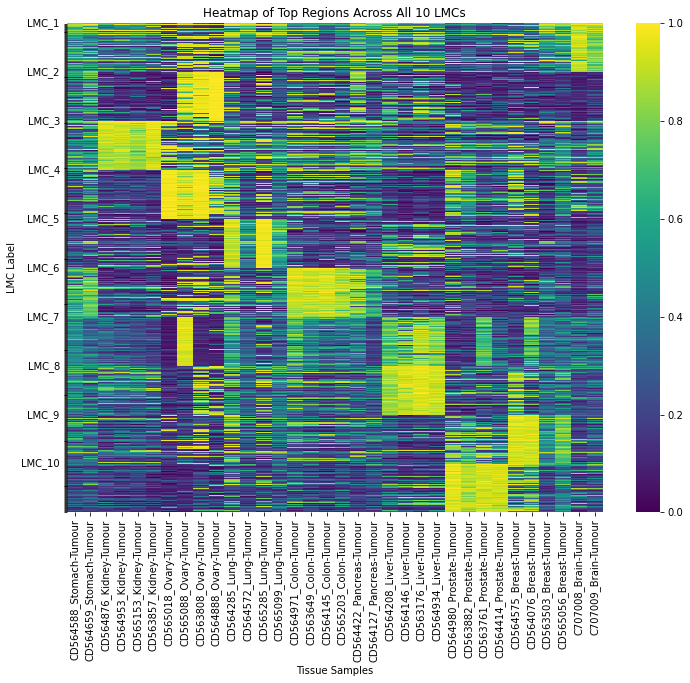

In [103]:
ranked_regions = np.argsort(-lmc, axis=0)  # Negate to sort in descending order


# Assuming that 'healthy_df' has an index or a column with the genomic region names
# and 'ranked_regions' is already computed as before

n_top_regions = 50
top_regions_indices_per_lmc = pd.DataFrame(index=range(n_top_regions))
top_regions_weights_per_lmc = pd.DataFrame(index=range(n_top_regions))

# Retrieve the names of the genomic regions from the DataFrame index or a specific column
genomic_region_names = tumour_df.index  # Replace with healthy_df['region_column_name'] if using a column

for i in range(n_lmc):
    top_indices = ranked_regions[:n_top_regions, i]  # Top regions for the ith LMC
    top_weights = lmc[top_indices, i]
    top_region_names = genomic_region_names[top_indices]  # Get the names of the top regions
    
    # Store the names and weights in separate DataFrames for the ith LMC
    top_regions_indices_per_lmc[f'LMC_{i+1}'] = top_region_names
    top_regions_weights_per_lmc[f'LMC_{i+1}'] = top_weights


# Define the number of top regions to consider for each LMC
n_top_regions = 50

# Initialize a list to hold the unique top regions and a list for their corresponding LMC labels
unique_top_regions = []
lmc_labels = []

# Iterate over each LMC to collect the top regions and their labels
for i in range(n_lmc):
    regions = list(top_regions_indices_per_lmc[f'LMC_{i+1}'])
    unique_top_regions.extend(regions)
    # Extend the label list with the current LMC label, repeated for the number of regions added
    lmc_labels.extend([f'LMC_{i+1}'] * len(regions))

# Now subset the healthy_df DataFrame with the unique top regions
top_regions_df = tumour_df.loc[unique_top_regions]

# Plot the heatmap
plt.figure(figsize=(12, 9))
ax = sns.heatmap(top_regions_df, cmap='viridis', yticklabels=lmc_labels, xticklabels=True)
plt.title(f"Heatmap of Top Regions Across All {n_lmc} LMCs")
plt.xlabel('Tissue Samples')
plt.ylabel('LMC Label')

# Modify the yticks to only show one label per LMC
yticks = ax.get_yticks()
# Set every nth label to be visible (n = number of regions per LMC), the rest will be set to empty string
ax.set_yticklabels(['' if (idx % n_top_regions) else label for idx, label in enumerate(lmc_labels)])

plt.show()


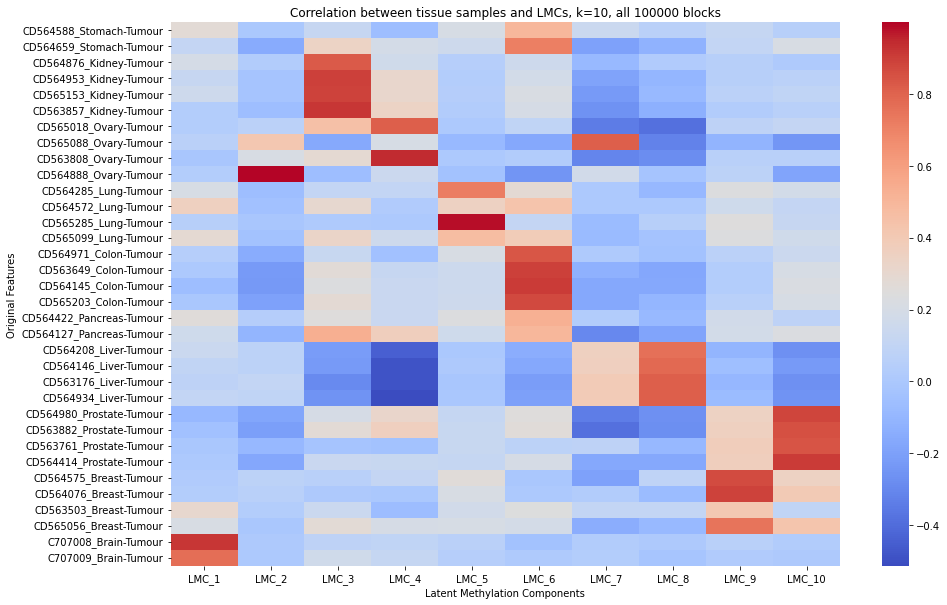

In [108]:

# Calculate correlations between original columns and LMCs
lmc_df = pd.DataFrame(lmc, index=tumour_df.index)
correlation_matrix = pd.DataFrame(np.corrcoef(tumour_df.T, lmc_df.T)[:tumour_df.shape[1], tumour_df.shape[1]:],
                                  index=tumour_df.columns, columns=[f"LMC_{i+1}" for i in range(n_lmc)])





# Plotting the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
# plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, top {topn_var} variance blocks")
plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, all {len(healthy_df)} blocks")

plt.ylabel("Original Features")
plt.xlabel("Latent Methylation Components")
plt.show()

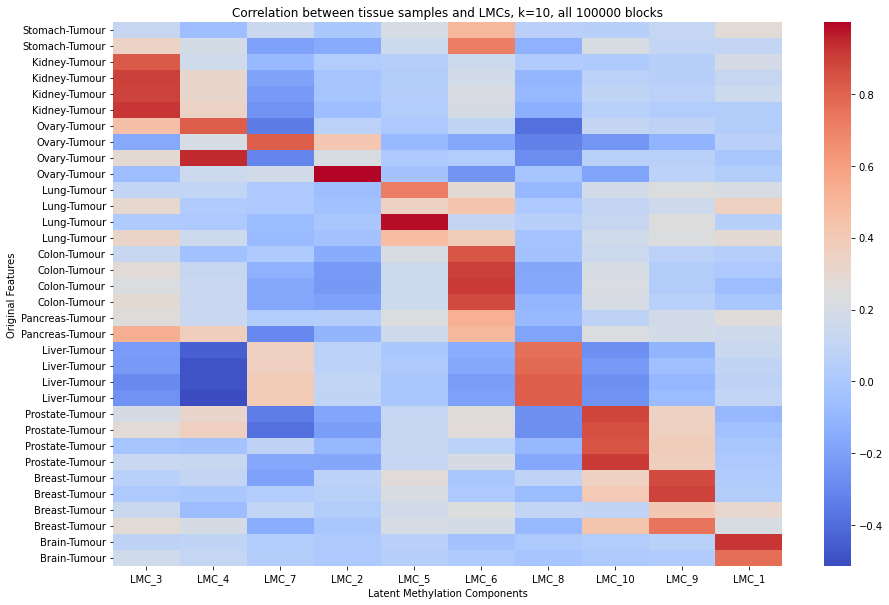

In [110]:
custom_lmc_order = [3,4,7,2,5,6,8,10,9,1]
lmc_string_order = [f"LMC_{u}" for u in custom_lmc_order]
[u for u in correlation_matrix.columns if u not in lmc_string_order]

tissue_labels = [id_tissue_map[col] for col in tumour_df.columns]

# Plotting the heatmap
plt.figure(figsize=(15, 10))
# sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
sns.heatmap(correlation_matrix[lmc_string_order], annot=False, cmap='coolwarm',yticklabels=tissue_labels)


plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, all {len(healthy_df)} blocks")

plt.ylabel("Original Features")
plt.xlabel("Latent Methylation Components")
plt.show()

### All samples

### Tumour subgroups

### Pan-cancer signatures

How can we use NMF to extract pan-cancer signatures

1. Try NMF with k = 2 on all healthy and cancer samples

In [111]:
df = df.loc[:,[u for u in df.columns if u not in sample_outliers]]

In [112]:
all_df = df.copy()
# all_df = df[[u for u in df.columns if id_tissue_map[u] not in blood_cell_types]]

In [113]:
tissue_sample_order = []

for tissue in healthy_tissue_types:
    if tissue not in ['Bone-Marrow','Thymus']:
        tissue_sample_order.extend(tissue_id_map[tissue])
        
for tissue in cancer_tissue_types:
    tissue_sample_order.extend(tissue_id_map[tissue])
    
    
all_df = all_df[[u for u in tissue_sample_order if u in all_df]]

In [114]:
all_df = all_df[[u for u in all_df.columns if 'Brain' not in u]]

In [115]:
## Calculate variance across rows, excluding the non-numeric columns
all_df['variance'] = all_df.var(axis=1)

topn_var = 100000
# Sort the DataFrame by 'variance' in descending order and select top n
all_df = all_df.sort_values('variance', ascending=False).head(topn_var)

# Drop the 'variance' column if it's no longer needed
all_df = all_df.drop(columns=['variance'])



In [118]:

# Assuming 'methylation_df' is your DataFrame

n_lmc = 32
# n_lmc = 3
nmf = NMF(n_components=n_lmc, init='random', random_state=0)
lmc = nmf.fit_transform(all_df)







/Users/felix/opt/anaconda3/envs/local_ds/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


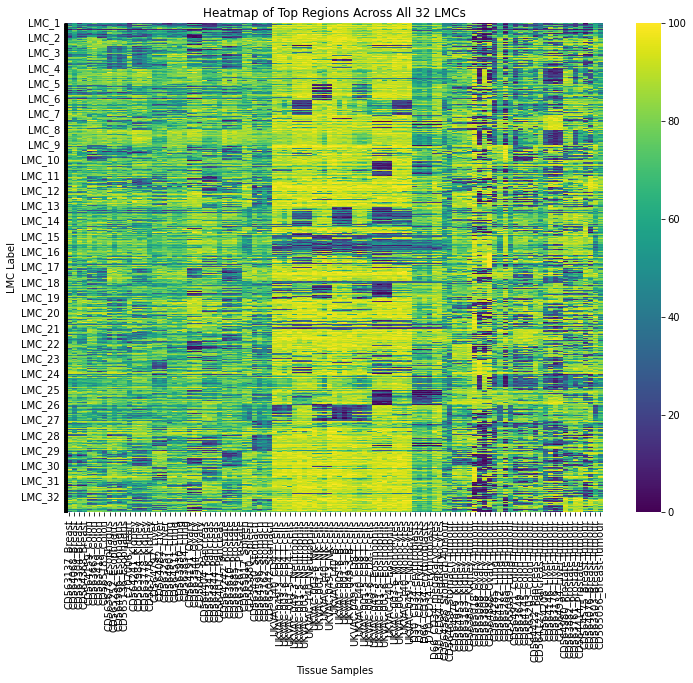

In [121]:
ranked_regions = np.argsort(-lmc, axis=0)  # Negate to sort in descending order

select_df = all_df

# Assuming that 'healthy_df' has an index or a column with the genomic region names
# and 'ranked_regions' is already computed as before

n_top_regions = 100
top_regions_indices_per_lmc = pd.DataFrame(index=range(n_top_regions))
top_regions_weights_per_lmc = pd.DataFrame(index=range(n_top_regions))

# Retrieve the names of the genomic regions from the DataFrame index or a specific column
genomic_region_names = select_df.index  # Replace with healthy_df['region_column_name'] if using a column

for i in range(n_lmc):
    top_indices = ranked_regions[:n_top_regions, i]  # Top regions for the ith LMC
    top_weights = lmc[top_indices, i]
    top_region_names = genomic_region_names[top_indices]  # Get the names of the top regions
    
    # Store the names and weights in separate DataFrames for the ith LMC
    top_regions_indices_per_lmc[f'LMC_{i+1}'] = top_region_names
    top_regions_weights_per_lmc[f'LMC_{i+1}'] = top_weights



# Initialize a list to hold the unique top regions and a list for their corresponding LMC labels
unique_top_regions = []
lmc_labels = []

# Iterate over each LMC to collect the top regions and their labels
for i in range(n_lmc):
    regions = list(top_regions_indices_per_lmc[f'LMC_{i+1}'])
    unique_top_regions.extend(regions)
    # Extend the label list with the current LMC label, repeated for the number of regions added
    lmc_labels.extend([f'LMC_{i+1}'] * len(regions))

# Now subset the healthy_df DataFrame with the unique top regions
top_regions_df = select_df.loc[unique_top_regions]

# Plot the heatmap
plt.figure(figsize=(12, 9))
ax = sns.heatmap(top_regions_df, cmap='viridis', yticklabels=lmc_labels, xticklabels=True)
plt.title(f"Heatmap of Top Regions Across All {n_lmc} LMCs")
plt.xlabel('Tissue Samples')
plt.ylabel('LMC Label')

# Modify the yticks to only show one label per LMC
yticks = ax.get_yticks()
# Set every nth label to be visible (n = number of regions per LMC), the rest will be set to empty string
ax.set_yticklabels(['' if (idx % n_top_regions) else label for idx, label in enumerate(lmc_labels)])

plt.show()


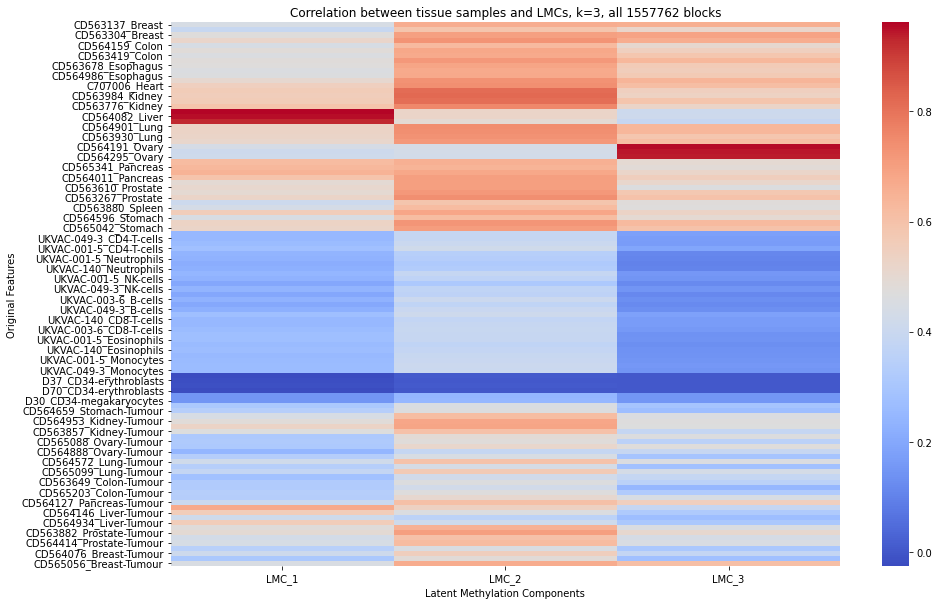

In [279]:

# Calculate correlations between original columns and LMCs
lmc_df = pd.DataFrame(lmc, index=all_df.index)
correlation_matrix = pd.DataFrame(np.corrcoef(all_df.T, lmc_df.T)[:all_df.shape[1], all_df.shape[1]:],
                                  index=all_df.columns, columns=[f"LMC_{i+1}" for i in range(n_lmc)])


# Plotting the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
# plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, top {topn_var} variance blocks")
plt.title(f"Correlation between tissue samples and LMCs, k={n_lmc}, all {len(healthy_df)} blocks")
plt.ylabel("Original Features")
plt.xlabel("Latent Methylation Components")
plt.show()